In [84]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import itertools
import glob
import csv
from scipy.spatial.transform import Rotation as R
from scipy.stats import binned_statistic
import math
from scipy.stats import norm
from scipy.signal import chirp, find_peaks, peak_widths
#plt.rcParams['text.usetex'] = True
#Importing modules for 3.x
#import analysis_tools
#from analysis_tools.andrew_hydro_sim_modules import simple_tools as tools
#from analysis_tools.andrew_hydro_sim_modules import hydro_sim_analysis as hydro

#importing for 2.7
from andrew_hydro_sim_modules import simple_tools as tools
from andrew_hydro_sim_modules import hydro_sim_analysis as hydro
#from andrew_hydro_sim_modules.hydro_sim_analysis import report_stellar_velocities
from andrew_hydro_sim_modules.simple_tools import get_distance_vector
from andrew_hydro_sim_modules.simple_tools import get_distance
from andrew_hydro_sim_modules.hydro_sim_analysis import Calc_average_L_shift
from andrew_hydro_sim_modules.hydro_sim_analysis import Rotate_to_z_axis
from andrew_hydro_sim_modules.hydro_sim_analysis import convert_to_cylindrical
from andrew_hydro_sim_modules import star_velocities as starvelo
from andrew_hydro_sim_modules.hydro_sim_analysis import save_test
from andrew_hydro_sim_modules.simple_tools import axis

In [14]:
#want to get the rotational velocity and velocity dispersion
#import all of Andrew's functions, see if I can get his vector_distance module
#hydro.report_stellar_velocities('./snapshot_m10xa_152.stars.hdf5','./galaxy_center_file.csv')
#hydro.report_velocities('./snapshot_m10xa_152.stars.hdf5')

host_center = np.loadtxt('./galaxy_center_file.csv',delimiter=',',dtype=object)
stellar_file = './snapshot_m10xc_152.stars.hdf5'
host_center = [i[1:4] for i in host_center if i[0][0:5] in stellar_file[11:16]]
print(host_center)
h = 0.71
host_center = np.array([[float(j)*(1000.0/h) for j in i] for i in host_center])
print(host_center)

velocities = [starvelo.report_stellar_velocities(stellar_file,i,40) for i in host_center]


[array(['17.0627', '9.648', '12.9653'], dtype=object), array(['17.4166', '9.5743', '12.9442'], dtype=object)]
[[24031.97183099 13588.73239437 18260.98591549]
 [24530.42253521 13484.92957746 18231.26760563]]
[ -89917.72272049 -137925.75120144 -196073.32484643]
[ -89917.72272049 -137925.75120144 -196073.32484643]
The rotational velocity is 30.5648538687 km/s
Velocity dispersion is 17.9658732049 km/s
V/sigma = 1.70127293676
The mass of the galaxy (out to 40 pc) = 8.09396311904 log(m*)
[-23079.2837307  -55810.53156612  37359.82067415]
[-23079.2837307  -55810.53156612  37359.82067415]
The rotational velocity is 15.8328626803 km/s
Velocity dispersion is 15.2620995727 km/s
V/sigma = 1.03739741737
The mass of the galaxy (out to 40 pc) = 6.94982223541 log(m*)


In [5]:
#create the function to get the velocity and mass data I need
def velocities_mass(stellar_file):
    host_center = np.loadtxt('./galaxy_center_file.csv',delimiter=',',dtype=object)
    stellar_file = stellar_file
    gal_name = [i[0] for i in host_center if i[0][0:5] in stellar_file[22:27]]
    host_center = [i[1:4] for i in host_center if i[0][0:5] in stellar_file[22:27]]
    print(host_center)
    print(gal_name)
    h = 0.71
    host_center = np.array([[float(j)*(1000.0/h) for j in i] for i in host_center])
    #gal_rad = raw_input('What is the galaxy radius?: ')
    velocities = [starvelo.report_stellar_velocities(stellar_file,i,float(raw_input('What is the galaxy radius?: '))) for i in host_center]
    print('The report for these galaxies: ',velocities)
    return velocities,gal_name 

In [131]:
#function for calculating the ellipticity
def calc_ellip(stellar_file,host_center,rad):
    f = h5py.File(stellar_file)
    host_center_variable = host_center 
    radius = rad #kpc as described in the paper
    print(rad)
    stars_part = f['PartType4']['Coordinates'][:]/h #PD_dict['star']['coords']
    stars_mass = f['PartType4']['Masses'][:]*(10**10.0)/h #PD_dict['star']['masses']
    stars_vel = f['PartType4']['Velocities'][:] #PD_dict['star']['velocities']
    stars_dist_val = get_distance(stars_part, host_center_variable) 
    dist_cut = (stars_dist_val<=radius)
    coord_cut = stars_part[dist_cut] 
    vel_cut = stars_vel[dist_cut]
    mass_cut = stars_mass[dist_cut]
    
    host_vel = np.mean(vel_cut,axis=0)
    shifted_vel = vel_cut-host_vel 
    shifted_coords_ellip = coord_cut-host_center_variable
    
    #figure out how to rotate over i (rotate specifically x-y)
    def cal_rotation(angle): 
        r = R.from_euler('z',angle, degrees=True)
        rotated_coords = r.apply(coord_cut) #rotation of i degrees around z 
        rotated_center = r.apply(host_center_variable)
        rotated_coordsx = r.apply(coord_cut)
        rotated_shifted_coordsx = rotated_coordsx-rotated_center
        x_center_rotated = rotated_center[0]
        y_center_rotated = rotated_center[1]
        z_center_rotated = rotated_center[2]
        vel_rotated = r.apply(shifted_vel)
        rotated_shifted_coords = np.abs(rotated_coords-rotated_center)
        rotated_shift = rotated_coords-rotated_center
        bincounts = 160
        #x-y
        x_rotated_right_cut = (rotated_coords[:,0]>x_center_rotated)
        right_hemisphere_rotated = rotated_coords[x_rotated_right_cut]

        x_rotated_left_cut = (rotated_coords[:,0]<x_center_rotated)
        left_hemisphere_rotated = rotated_coords[x_rotated_left_cut]

        #right hemisphere
        coord_shift_x_right = right_hemisphere_rotated-rotated_center
        right_hemisphere_rotated_x_mass = mass_cut[x_rotated_right_cut]
        vel_shift_right = vel_rotated[x_rotated_right_cut]
        #print(vel_shift_right[0:15])

        L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_rotated_x_mass,vel_shift_right)
        assert L_stars_x.shape==tuple((3,))
        #print(L_stars_x)
        part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift_right,L_stars_x)
        part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
        V_theta_x_right = np.mean(vel_cyl_x[:,1])
        #print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

        #left hemisphere
        coord_shift_x_left = left_hemisphere_rotated-rotated_center
        left_hemisphere_rotated_x_mass = mass_cut[x_rotated_left_cut]
        vel_shift_left = vel_rotated[x_rotated_left_cut]
        #print(len(vel_shift_left))
        #print(coord_shift_x_left[0:15],left_hemisphere_rotated_x_mass[0:15],vel_shift_left[0:15])

        L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_rotated_x_mass,vel_shift_left)
        assert L_stars_x.shape==tuple((3,))
        #print(L_stars_x)
        part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift_left,L_stars_x)
        part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
        V_theta_x_left = np.mean(vel_cyl_x[:,1])
        #print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
        vrot_diff_x =  V_theta_x_left - V_theta_x_right
        #print('The difference between the left and right hemispheres is: {}'.format(vrot_diff_x))
        
        #bin the stars and calc ellip (x-y)
        np2dhist,bin_edges = np.histogram(rotated_shifted_coordsx[:,0],bins=bincounts)
        np2dhist_z,bin_edges_z = np.histogram(rotated_shifted_coordsx[:,1],bins=bincounts)

        bin_values = np.array([(bin_edges[i+1]+bin_edges[i])/2 for i in range(len(bin_edges)-1)]) 
        bin_values_z = np.array([(bin_edges_z[i+1]+bin_edges_z[i])/2 for i in range(len(bin_edges_z)-1)])
        #print(bin_values)
        np2d_weighted = np.sum(np2dhist*(bin_values**2))
        np2d_weighted_z = np.sum(np2dhist_z*(bin_values_z**2))
        ellipticity_xy = max([(1 - np.sqrt((np2d_weighted)/(np2d_weighted_z))),(1 - np.sqrt((np2d_weighted_z)/(np2d_weighted)))])

        #y
        r = R.from_euler('x',angle, degrees=True)
        rotated_coords = r.apply(coord_cut) #rotation of i degrees around z 
        rotated_center = r.apply(host_center_variable)
        rotated_coordsy = r.apply(coord_cut)
        rotated_shifted_coordsy = rotated_coordsy-rotated_center
        x_center_rotated = rotated_center[0]
        y_center_rotated = rotated_center[1]
        z_center_rotated = rotated_center[2]
        vel_rotated = r.apply(shifted_vel)
        rotated_shifted_coords = np.abs(rotated_coords-rotated_center)
        rotated_shift = rotated_coords-rotated_center
        
        x_rotated_right_cut = (rotated_coords[:,1]>y_center_rotated)
        right_hemisphere_rotated = rotated_coords[x_rotated_right_cut]

        x_rotated_left_cut = (rotated_coords[:,1]<y_center_rotated)
        left_hemisphere_rotated = rotated_coords[x_rotated_left_cut]

        #right hemisphere
        coord_shift_x_right = right_hemisphere_rotated-rotated_center
        right_hemisphere_rotated_x_mass = mass_cut[x_rotated_right_cut]
        vel_shift_right = vel_rotated[x_rotated_right_cut]
        #print(vel_shift_right[0:15])

        L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_rotated_x_mass,vel_shift_right)
        assert L_stars_x.shape==tuple((3,))
        #print(L_stars_x)
        part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift_right,L_stars_x)
        part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
        V_theta_y_right = np.mean(vel_cyl_x[:,1])
        #print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

        #left hemisphere
        coord_shift_x_left = left_hemisphere_rotated-rotated_center
        left_hemisphere_rotated_x_mass = mass_cut[x_rotated_left_cut]
        vel_shift_left = vel_rotated[x_rotated_left_cut]
        #print(len(vel_shift_left))
        #print(coord_shift_x_left[0:15],left_hemisphere_rotated_x_mass[0:15],vel_shift_left[0:15])

        L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_rotated_x_mass,vel_shift_left)
        assert L_stars_x.shape==tuple((3,))
        #print(L_stars_x)
        part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift_left,L_stars_x)
        part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
        V_theta_y_left = np.mean(vel_cyl_x[:,1])
        
        #print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
        vrot_diff_y =  V_theta_y_left - V_theta_y_right
        
        #bin the stars and calc ellip(y)
        np2dhist,bin_edges = np.histogram(rotated_shifted_coordsy[:,1],bins=bincounts)
        np2dhist_z,bin_edges_z = np.histogram(rotated_shifted_coordsy[:,2],bins=bincounts)

        bin_values = np.array([(bin_edges[i+1]+bin_edges[i])/2 for i in range(len(bin_edges)-1)]) 
        #print(bin_values)
        bin_values_z = np.array([(bin_edges_z[i+1]+bin_edges_z[i])/2 for i in range(len(bin_edges_z)-1)])
        #print(bin_values_z)
        #print(bin_values)
        np2d_weighted = np.sum(np2dhist*(bin_values**2))
        np2d_weighted_z = np.sum(np2dhist_z*(bin_values_z**2))
        ellipticity_yz = max([(1 - np.sqrt((np2d_weighted)/(np2d_weighted_z))),(1 - np.sqrt((np2d_weighted_z)/(np2d_weighted)))])

        #zx
        r = R.from_euler('y',angle, degrees=True)
        rotated_coords = r.apply(coord_cut) #rotation of i degrees around z 
        rotated_coordsz = r.apply(coord_cut)
        rotated_center = r.apply(host_center_variable)
        rotated_shifted_coordsz = rotated_coordsz-rotated_center
        x_center_rotated = rotated_center[0]
        y_center_rotated = rotated_center[1]
        z_center_rotated = rotated_center[2]
        vel_rotated = r.apply(shifted_vel)
        rotated_shifted_coords = np.abs(rotated_coords-rotated_center)
        rotated_shift = rotated_coords-rotated_center
        
        x_rotated_right_cut = (rotated_coords[:,2]>z_center_rotated)
        right_hemisphere_rotated = rotated_coords[x_rotated_right_cut]

        x_rotated_left_cut = (rotated_coords[:,2]<z_center_rotated)
        left_hemisphere_rotated = rotated_coords[x_rotated_left_cut]

        #right hemisphere
        coord_shift_x_right = right_hemisphere_rotated-rotated_center
        right_hemisphere_rotated_x_mass = mass_cut[x_rotated_right_cut]
        vel_shift_right = vel_rotated[x_rotated_right_cut]
        #print(vel_shift_right[0:15])

        L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_rotated_x_mass,vel_shift_right)
        assert L_stars_x.shape==tuple((3,))
        #print(L_stars_x)
        part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift_right,L_stars_x)
        part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
        V_theta_z_right = np.mean(vel_cyl_x[:,1])
        #print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

        #left hemisphere
        coord_shift_x_left = left_hemisphere_rotated-rotated_center
        left_hemisphere_rotated_x_mass = mass_cut[x_rotated_left_cut]
        vel_shift_left = vel_rotated[x_rotated_left_cut]
        #print(len(vel_shift_left))
        #print(coord_shift_x_left[0:15],left_hemisphere_rotated_x_mass[0:15],vel_shift_left[0:15])

        L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_rotated_x_mass,vel_shift_left)
        assert L_stars_x.shape==tuple((3,))
        #print(L_stars_x)
        part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift_left,L_stars_x)
        part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
        V_theta_z_left = np.mean(vel_cyl_x[:,1])
        
        #print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
        vrot_diff_z =  V_theta_z_left - V_theta_z_right
        
        #bin the stars and calc ellip
        np2dhist,bin_edges = np.histogram(rotated_shifted_coordsz[:,0],bins=bincounts)
        np2dhist_z,bin_edges_z = np.histogram(rotated_shifted_coordsz[:,2],bins=bincounts)

        bin_values = np.array([(bin_edges[i+1]+bin_edges[i])/2 for i in range(len(bin_edges)-1)]) 
        bin_values_z = np.array([(bin_edges_z[i+1]+bin_edges_z[i])/2 for i in range(len(bin_edges_z)-1)])
        #print(bin_values)
        np2d_weighted = np.sum(np2dhist*(bin_values**2))
        np2d_weighted_z = np.sum(np2dhist_z*(bin_values_z**2))
        ellipticity_zx = max([(1 - np.sqrt((np2d_weighted)/(np2d_weighted_z))),(1 - np.sqrt((np2d_weighted_z)/(np2d_weighted)))])

        #coordinates for final plots
        coords_zx = rotated_shifted_coordsz[:,[2,0]]
        coords_yz = rotated_shifted_coordsy[:,[1,2]]
        coords_xy = rotated_shifted_coordsx[:,[0,1]]
        coords_list = np.array([coords_zx,coords_yz,coords_xy])
        
        #Dubinsky ellipticities
        dub_ellipxy = axis(rotated_shifted_coordsx[:,[0,1]],rad,quiet=True)[0]
        dub_ellipzx = axis(rotated_shifted_coordsz[:,[2,0]],rad,quiet=True)[0]
        dub_ellipyz = axis(rotated_shifted_coordsy[:,[1,2]],rad,quiet=True)[0]
        
        dubinski_ellipxy = np.sqrt(1-(dub_ellipxy)**2)
        dubinski_ellipzx = np.sqrt(1-(dub_ellipzx)**2)
        dubinski_ellipyz = np.sqrt(1-(dub_ellipyz)**2)
        
        #Outputs
        vrot_diffs = np.array([vrot_diff_z,vrot_diff_y,vrot_diff_x])
        vrot_diff_max = max(np.abs(vrot_diffs))
        projection = np.array(['zx','yz','xy'])
        ellipticities = np.array([ellipticity_zx,ellipticity_yz,ellipticity_xy])
        ellipticity = ellipticities[np.where(np.abs(vrot_diffs) == vrot_diff_max)]
        coordinates = coords_list[np.where(np.abs(vrot_diffs) == vrot_diff_max)]
        projection_name = projection[np.where(np.abs(vrot_diffs) == vrot_diff_max)]
        
        
        return vrot_diff_max, ellipticity, coordinates, projection_name, dubinski_ellipxy, dubinski_ellipzx, dubinski_ellipyz, angle
    
    #Find the values for all the different rotations
    vrot_diffs = np.array([cal_rotation(i) for i in np.arange(0,360,10)])
    vrot_max_diffs = vrot_diffs[:,0]
    ellips = vrot_diffs[:,1]
    coords_plot = vrot_diffs[:,2]
    projs = vrot_diffs[:,3]   
    #get the different eccentricities for the various rotations
    x_ellip = np.array([i[4] for i in vrot_diffs])
    z_ellip = np.array([i[5] for i in vrot_diffs])
    y_ellip = np.array([i[6] for i in vrot_diffs])
    angles = np.array([i[7] for i in vrot_diffs])
    
    #print(x_ellip.shape)
    #print(angles.shape)
    
    #get all the values for the rotation with max velocity difference
    max_vrot_diff_x = max(vrot_max_diffs)
    gal_ellip = ellips[np.where(vrot_max_diffs==max_vrot_diff_x)]
    gal_coords = coords_plot[np.where(vrot_max_diffs==max_vrot_diff_x)]
    proj_name = projs[np.where(vrot_max_diffs==max_vrot_diff_x)]
    
    #calculate dubinski ellip.
    
    dubinski_testxy = axis(shifted_coords_ellip[:,[0,1]],rad,quiet=False)
    axis_ratioxy = dubinski_testxy[0]
    dubinski_ellip = np.sqrt(1-(axis_ratioxy)**2)
    
    #calculate correct dubinski ellipticity
    dubinski_ellipticity = axis(gal_coords[0][0][:,[0,1]],rad,quiet=False)
    axis_ratio = dubinski_ellipticity[0]
    dubinski_actual_ellip = np.sqrt(1-(axis_ratio)**2)
    
    global points
    points += 1
    
    axwidth = 3
    axlength = 12
    fontsize=32
    fontsizetick = 18
    plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsizetick)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsizetick)
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_markersize(18)
        line.set_markeredgewidth(3)
    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_fontsize(fontsizetick/2)
    for tick in ax.yaxis.get_minor_ticks():
        tick.label1.set_fontsize(fontsizetick/2)
    #note to self, the plot parameters need to be redone for each separate plot
    ax.tick_params(which='major',width=axwidth,length=axlength+5)
    ax.tick_params(which='minor',width=axwidth,length=axlength)
    
    plt.scatter(gal_coords[0][0][:,0],gal_coords[0][0][:,1],s=0.05)
    plt.autoscale(enable='false')
    plt.show()
    print("Binned e =",gal_ellip[0][0])
    print("Dubinski ellipticity =",dubinski_actual_ellip)
    print('Projection axis is:',proj_name[0][0])
    
    #XY Test Plot
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsizetick)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsizetick)
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_markersize(18)
        line.set_markeredgewidth(3)
    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_fontsize(fontsizetick/2)
    for tick in ax.yaxis.get_minor_ticks():
        tick.label1.set_fontsize(fontsizetick/2)
    ax.tick_params(which='major',width=axwidth,length=axlength+5)
    ax.tick_params(which='minor',width=axwidth,length=axlength)
    
    plt.scatter(shifted_coords_ellip[:,0],shifted_coords_ellip[:,1],s=0.05)
    plt.autoscale(enable='false')
    plt.show()
    print('2D Dubinski test for XY:',dubinski_ellip)
    print('Second plot is XY projection for 2D test')
    
    #XY Ellip vs angle
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsizetick)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsizetick)
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_markersize(18)
        line.set_markeredgewidth(3)
    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_fontsize(fontsizetick/2)
    for tick in ax.yaxis.get_minor_ticks():
        tick.label1.set_fontsize(fontsizetick/2)
    ax.tick_params(which='major',width=axwidth,length=axlength+5)
    ax.tick_params(which='minor',width=axwidth,length=axlength)
    
    plt.scatter(angles,x_ellip,s=10)
    ax.set_xlabel('Angle',fontsize=18)
    ax.set_ylabel('XY Eccentricity',fontsize=18)
    plt.autoscale(enable='false')
    plt.show()
    
    print('One galaxy done')
    
    return gal_ellip,max_vrot_diff_x
    

In [7]:
#testing the plots of galaxies to get a visual of how the ellipticity changes with line-of-sight
stell_file_name = './star_files/snapshot_m10xa_152.stars.hdf5'
f = h5py.File('./star_files/snapshot_m10xa_152.stars.hdf5')
host_center = np.loadtxt('./galaxy_center_file.csv',delimiter=',',dtype=object)
host_center = [i[1:4] for i in host_center if i[0][0:5] in stell_file_name[22:27]]
h = 0.71
host_center = np.array([[float(j)*(1000.0/h) for j in i] for i in host_center])
#print(host_center)
host_center_variable = host_center 
#print(host_center_variable[0])
radius = 7 #kpc
stars_part = f['PartType4']['Coordinates'][:]/h #PD_dict['star']['coords']
stars_mass = f['PartType4']['Masses'][:]*(10**10.0)/h #PD_dict['star']['masses']
stars_vel = f['PartType4']['Velocities'][:] #PD_dict['star']['velocities']
stars_dist_val = get_distance(stars_part, host_center_variable[0]) 
dist_cut = (stars_dist_val<=radius)
coord_cut = stars_part[dist_cut] 
vel_cut = stars_vel[dist_cut]
mass_cut = stars_mass[dist_cut]

host_vel = np.mean(vel_cut,axis=0)
shifted_vel = vel_cut-host_vel

#now have all stars in the radius required
#split them into their hemispheres 
#hemispheres for x-y
x_center = host_center_variable[0][0]
y_center = host_center_variable[0][1]
z_center = host_center_variable[0][2]

x_right_cut = (coord_cut[:,0]>x_center)
x_left_cut = (coord_cut[:,0]<x_center)

right_hemisphere_x = coord_cut[x_right_cut]
right_hemisphere_x_velo = shifted_vel[x_right_cut]
right_hemisphere_x_mass = mass_cut[x_right_cut]

left_hemisphere_x = coord_cut[x_left_cut]
left_hemisphere_x_velo = shifted_vel[x_left_cut]
left_hemisphere_x_mass = mass_cut[x_left_cut]


#calculate the vrot (velocity measurement) for right/left hemisphere 
#right hemisphere
coord_shift_x_right = right_hemisphere_x-host_center_variable[0]
vel_shift = right_hemisphere_x_velo
#print(vel_shift[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_x_mass,vel_shift)
assert L_stars_x.shape==tuple((3,))
print('L_stars_x')
#print(L_stars_x[0:15])
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_right = np.mean(vel_cyl_x[:,1])
print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

#left hemisphere
coord_shift_x_left = left_hemisphere_x-host_center_variable[0]
vel_shift = left_hemisphere_x_velo
print(len(vel_shift))
#print(coord_shift_x_left[0:15],left_hemisphere_x_mass[0:15],vel_shift[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_x_mass,vel_shift)
assert L_stars_x.shape==tuple((3,))
print(L_stars_x[0:15])
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_left = np.mean(vel_cyl_x[:,1])
print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
vrot_diff_x =  V_theta_x_left - V_theta_x_right
print('The difference between the left and right hemispheres is: {}'.format(vrot_diff_x))

#figure out how to rotate over i (rotate specifically x-y)
r = R.from_euler('z', 0, degrees=True)
rotated_coords = r.apply(coord_cut) #rotation of 90 degrees around z 
rotated_center = r.apply(host_center_variable[0])
x_center_rotated = rotated_center[0]
vel_rotated = r.apply(shifted_vel)
rotated_shifted_coords = rotated_coords-rotated_center
x_center_rotated = rotated_center[0]
y_center_rotated = rotated_center[1]
z_center_rotated = rotated_center[2]

print(rotated_shifted_coords[0:15])

x_rotated_right_cut = (rotated_coords[:,0]>x_center_rotated)
right_hemisphere_rotated = rotated_coords[x_rotated_right_cut]

x_rotated_left_cut = (rotated_coords[:,0]<x_center_rotated)
left_hemisphere_rotated = rotated_coords[x_rotated_left_cut]

#right hemisphere
coord_shift_x_right = right_hemisphere_rotated-rotated_center
right_hemisphere_rotated_x_mass = mass_cut[x_rotated_right_cut]
vel_shift_right = vel_rotated[x_rotated_right_cut]
#print(vel_shift_right[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_rotated_x_mass,vel_shift_right)
assert L_stars_x.shape==tuple((3,))
#print(L_stars_x)
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift_right,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_right = np.mean(vel_cyl_x[:,1])
print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

#left hemisphere
coord_shift_x_left = left_hemisphere_rotated-rotated_center
left_hemisphere_rotated_x_mass = mass_cut[x_rotated_left_cut]
vel_shift_left = vel_rotated[x_rotated_left_cut]
#print(len(vel_shift_left))
#print(coord_shift_x_left[0:15],left_hemisphere_rotated_x_mass[0:15],vel_shift_left[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_rotated_x_mass,vel_shift_left)
assert L_stars_x.shape==tuple((3,))
print(L_stars_x)
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift_left,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_left = np.mean(vel_cyl_x[:,1])
print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
vrot_diff_x =  V_theta_x_left - V_theta_x_right
print('The difference between the left and right hemispheres is: {}'.format(vrot_diff_x))

weighted_sum_x = binned_statistic(rotated_shifted_coords[:,0],rotated_shifted_coords[:,0],statistic='sum',bins=200)
weighted_sum_y = binned_statistic(rotated_shifted_coords[:,1],rotated_shifted_coords[:,1],statistic='sum',bins=200)
ellipticity = 1 - np.sqrt(np.sum(weighted_sum_x[0])/np.sum(weighted_sum_y[0]))
print('the ellip is', ellipticity)
#print(test_sum_y[0])

#y
ry = R.from_euler('x', 90, degrees=True)
rotated_coordsyz = ry.apply(coord_cut) #rotation of 90 degrees around z 

xy_rotated_right_cut = (rotated_coords[:,1]>y_center_rotated)
right_hemisphere_rotated = rotated_coords[x_rotated_right_cut]

x_rotated_left_cut = (rotated_coords[:,1]<y_center_rotated)
left_hemisphere_rotated = rotated_coords[x_rotated_left_cut]

#right hemisphere
coord_shift_x_right = right_hemisphere_rotated-rotated_center
right_hemisphere_rotated_x_mass = mass_cut[x_rotated_right_cut]
vel_shift_right = vel_rotated[x_rotated_right_cut]
#print(vel_shift_right[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_rotated_x_mass,vel_shift_right)
assert L_stars_x.shape==tuple((3,))
#print(L_stars_x)
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift_right,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_right = np.mean(vel_cyl_x[:,1])
#print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

#left hemisphere
coord_shift_x_left = left_hemisphere_rotated-rotated_center
left_hemisphere_rotated_x_mass = mass_cut[x_rotated_left_cut]
vel_shift_left = vel_rotated[x_rotated_left_cut]
#print(len(vel_shift_left))
#print(coord_shift_x_left[0:15],left_hemisphere_rotated_x_mass[0:15],vel_shift_left[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_rotated_x_mass,vel_shift_left)
assert L_stars_x.shape==tuple((3,))
#print(L_stars_x)
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift_left,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_left = np.mean(vel_cyl_x[:,1])

#print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
vrot_diff_y =  V_theta_x_left - V_theta_x_right

#z
x_rotated_right_cut = (rotated_coords[:,2]>z_center_rotated)
right_hemisphere_rotated = rotated_coords[x_rotated_right_cut]

x_rotated_left_cut = (rotated_coords[:,2]<z_center_rotated)
left_hemisphere_rotated = rotated_coords[x_rotated_left_cut]

#right hemisphere
coord_shift_x_right = right_hemisphere_rotated-rotated_center
right_hemisphere_rotated_x_mass = mass_cut[x_rotated_right_cut]
vel_shift_right = vel_rotated[x_rotated_right_cut]
#print(vel_shift_right[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_right,right_hemisphere_rotated_x_mass,vel_shift_right)
assert L_stars_x.shape==tuple((3,))
#print(L_stars_x)
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_right,vel_shift_right,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_right = np.mean(vel_cyl_x[:,1])
#print('Vrot for right hemisphere (x/y) is: {}'.format(V_theta_x_right))

#left hemisphere
coord_shift_x_left = left_hemisphere_rotated-rotated_center
left_hemisphere_rotated_x_mass = mass_cut[x_rotated_left_cut]
vel_shift_left = vel_rotated[x_rotated_left_cut]
#print(len(vel_shift_left))
#print(coord_shift_x_left[0:15],left_hemisphere_rotated_x_mass[0:15],vel_shift_left[0:15])

L_stars_x = Calc_average_L_shift(coord_shift_x_left,left_hemisphere_rotated_x_mass,vel_shift_left)
assert L_stars_x.shape==tuple((3,))
#print(L_stars_x)
part_rotate_x, vel_rotate_x =  Rotate_to_z_axis(coord_shift_x_left,vel_shift_left,L_stars_x)
part_cyl_x, vel_cyl_x = convert_to_cylindrical(part_rotate_x,vel_rotate_x,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0])
V_theta_x_left = np.mean(vel_cyl_x[:,1])

#print('Vrot for left hemisphere (x/y) is: {}'.format(V_theta_x_left))
vrot_diff_z =  V_theta_x_left - V_theta_x_right

weighted_sum_x = binned_statistic(np.abs(rotated_shifted_coords[:,0]),np.abs(rotated_shifted_coords[:,0]),statistic='sum',bins=200)
weighted_sum_z = binned_statistic(np.abs(rotated_shifted_coords[:,2]),np.abs(rotated_shifted_coords[:,2]),statistic='sum',bins=200)
ellipticityzx = (1 - np.sqrt(np.sum(weighted_sum_x[0])/np.sum(weighted_sum_z[0])))
test_ellipzx = 1-np.sqrt(np.sum(np.abs(rotated_shifted_coords[:,0]))/np.sum(np.abs(rotated_shifted_coords[:,2])))
print(np.sum(weighted_sum_x[0]),np.sum(weighted_sum_z[0]))
#np hist test
np2dhist,bin_edges = np.histogram(np.abs(rotated_shifted_coords[:,0]),bins=20)
np2dhist_z,bin_edges_z = np.histogram(np.abs(rotated_shifted_coords[:,1]),bins=20)
bin_values = bin_edges 
bin_values_z = bin_edges_z
print(bin_edges)
print('bin diff: ',np.diff(bin_edges[0]))
print(np2dhist)

np2d_weighted = np.sum(np2dhist*bin_values)
np2d_weighted_z = np.sum(np2dhist_z*bin_values_z)
print('weighted bins',np2d_weighted)
test_ellip_zx = (1 - np.sqrt(np.sum(np2d_weighted)/np.sum(np2d_weighted_z)))

print('the ellipzx is', ellipticityzx)
print('test ellip:',test_ellip_zx)

#test photutils ellipticity
#from photutils.isophote import Ellipse
#xshiftedcoords = rotated_shifted_coords[:,0]
#yshiftedcoords = rotated_shifted_coords[:,1]
#zshiftedcoords = rotated_shifted_coords[:,2]

#datagrid = np.zeros((int(round(np.max(xshiftedcoords))), int(round(np.max(yshiftedcoords)))))
#plt.imshow(datagrid)
#ellipse = Ellipse(rotated_shifted_coords[:,:2],geometry=None) #all rows, two columns
#isolist = ellipse.fit_image()
#print(isolist.eps)



vrot_diff_max = max([vrot_diff_z,vrot_diff_y,vrot_diff_x])
print(vrot_diff_max)

dubinski_test = axis(rotated_shifted_coords,8)
semimajor_axis = dubinski_test[1]
semiminor_axis = dubinski_test[0]
dublinski_ellip = np.sqrt(1-((semiminor_axis)**2)/((semimajor_axis)**2))
print('mbk test:',dublinski_ellip)
#plot a few of the galaxies along different line-of-sights
plt.scatter(right_hemisphere_x[:,0],right_hemisphere_x[:,1]) #x-y right half
plt.show()
plt.scatter(coord_cut[:,0],coord_cut[:,1]) #x-y plot
plt.show()
print('x-y plot')
plt.scatter(coord_cut[:,1],coord_cut[:,2]) #x-y plot
plt.autoscale(enable='false')
plt.show()
print('y-z')
plt.scatter(rotated_coordsyz[:,1],rotated_coordsyz[:,2]) #x-y plot
plt.autoscale(enable='false')
plt.show()
print('y-z rotated')
plt.scatter(rotated_shifted_coords[:,2],rotated_shifted_coords[:,0]) #z-x rotated plot
plt.show()
plt.scatter(right_hemisphere_rotated[:,2],right_hemisphere_rotated[:,0]) #z-x rotated right half
plt.show()
plt.scatter(left_hemisphere_rotated[:,2],left_hemisphere_rotated[:,0]) #z-x rotated left half
plt.show()
#plt.hist(np2dhist,bins=bin_values)
#plt.show()
# plt.scatter(coord_cut[:,0],coord_cut[:,2])
# plt.show()
# plt.scatter(coord_cut[:,1],coord_cut[:,2])
# plt.show()

L_stars_x
Vrot for right hemisphere (x/y) is: 8.15295823126
12864
[0.67973692 0.05711138 0.73122911]
Vrot for left hemisphere (x/y) is: 8.58722642207
The difference between the left and right hemispheres is: 0.434268190812
[[-6.43316372e-02  2.39699762e+00  1.07986463e-01]
 [-5.67615309e-04  2.36713352e+00  1.12903375e-01]
 [-3.54480400e-02  2.42023643e+00  2.59862700e-01]
 [-4.91709265e-02  2.24976307e+00  7.13941907e-02]
 [-1.38754901e-01  1.98284303e+00 -4.74310912e-01]
 [-2.33869837e-02  1.92474334e+00 -4.74905701e-01]
 [-3.12045680e-02  2.16350321e+00 -4.38392613e-01]
 [-1.72141754e-01  2.10733006e+00 -7.91522254e-01]
 [-9.37692061e-02  2.13109783e+00 -7.32462395e-01]
 [-2.60095393e-02  2.08222257e+00 -5.94211598e-01]
 [-5.58901342e-02  2.13325202e+00 -6.57231678e-01]
 [ 5.26020418e-02  1.89925648e+00 -6.46721167e-01]
 [-8.47452659e-02 -1.26777368e-01  2.46397503e-01]
 [-1.55635445e-01 -9.04083976e-03  1.20568638e-01]
 [-1.52158677e-02 -8.46882899e-02 -2.18394500e-03]]
Vrot for ri

AxisError: axis -1 is out of bounds for array of dimension 0

In [117]:
#2d version
def axis(arr_in, rad, shell=False, axes_out=False, fix_volume=True, quiet=False):
    import numpy as np
    import scipy.linalg as linalg
    """Compute axis ratios iteratively.

    WORK IN PROGRESS -- Needs to be checked.
    2D VERSION -- Worked on by Thomas Seive. Primary purpose is to calculate
    the ellipticity of a galaxy while only considering one projection (two axes).
    This version cannot make use of the shell feature found in the 3d version
    Here is just a small change to the code to try and test this github push/pull feature
    Here is another line that I've added. Slowly getting the hang of this git stuff!
    Adding this line for the github test on Mac; another test to see if I can add without
    needing to log in to github
    Managed to make a change on my mac and get the change on my pc! Let's do the reverse
    Don't even need to close the file for it to refresh with the new changes! (at least on mac)
    And the same on PC! I can now officially use github to work on my code :-)
    End 2D code//

    May want to add capability to compute axis ratios at multiple
    different radii in one function call (w/ a loop?) 

    See Dubinski & Carlberg (1991) for details

    INPUTS:
    arr_in: array of particle positions, assumed to be centered. A 2D array for the 2D case
    rad: radius to compute axis ratios.  If computing axis ratios in
    shells, rad should be a two-element list / array, with rad[0] =
    inner radius of shell and rad[1] = outer radius of shell.
    Otherwise, rad should be a real number equal to the radius within
    which to compute the axis ratios


    OPTIONAL INPUTS:
    shell=False: by default, compute cumulative axis ratio
    (i.e. for all particles within radius r).  If shell=True, compute
    axis ratio in an ellipsoidal shell instead.
    axes_out=False:  if True, also return principal axes (in ascending order)
    fix_volume=True: keep the volume of the ellipsoid constant while iterating.
    If false, keep the semi-major axis equal to the initial (spherical) search
    radius. This will result in a smaller effective volume.
    quiet=False: if set to true, suppress information that is printed
    on each iteration
    """
    if quiet == False:
        print('Radius:',rad)
        
    def calc_inertia(arr_in, axrat_in):

        """calculate the modified moment of inertia tensor and get its eigenvalues and eigenvalues"""
        tensor=np.zeros([2,2])
        # given initial values for primary axes, compute ellipsoidal
        # radius of each particle (rp2 is not square rooted because it is squared in the next step, i.e. they cancel)
        rp2=(arr_in[:,0]**2/axrat_in[0]**2 + arr_in[:,1]**2/axrat_in[0]**2) #(Thomas)changed this line
        #made axrat_in call only the [0] element because I will only have one axial ratio to guess

        # construct the moment of inertial tensor to be diagonalized:
        for i in range(2): #(Thomas)changed this line, rp2 is the "a" from the paper
            for j in range(2):
                tensor[i,j]=(arr_in[:,i]*arr_in[:,j]/rp2).sum()
        
        evecs=linalg.eig(tensor)
        
        # return a tuple with eigenvalues and eigenvectors; 
        # eigenvalues=evecs[0], eigenvectors=evecs[1]
        return evecs

    cnt=0
    # initial guess for principal axes:
    evs0=np.array([[1e0,0e0],[0e0, 1e0]]) #(Thomas) changed this line
    # initial guess for axis ratios: 
    axes=np.array([1e0]) #(Thomas) changed this line: only give one initial guess because we are only calculating one 
    #axial ratio
    avdiff=1e0

    rad=np.asarray(rad)
    # ******************************
    # fixed portion of code (From June 8, 2017)
    while avdiff > 0.01:
        axtemp=axes.copy()
        # compute ellipsoidal radius of each particle:  (Thomas)This is a radius for each particle
        dist2=(
               arr_in[:,0]**2/axes[0]**2 +
               arr_in[:,1]**2/axes[0]**2)**0.5
            #(Thomas)Changed the line above
        # find locations of particles between rad[0] and rad[1]
        if not fix_volume:
            r_ell=rad
        else:
            r_ell=(rad**3/axes[0]/axes[0])**(1e0/3e0) #(Thomas): Broke this line so
            #dont use the shells! 
            
 
        # current version keeps volume same as original spherical
        # volume rather than keeping principal axis same as
        # initial radius
        if shell == True:
            locs=((dist2 < r_ell[1]) & 
                  (dist2 > r_ell[0])).nonzero()[0]
        else:
            locs=(dist2 < r_ell).nonzero()[0]

            # ******************************

        # get eigenvectors and eigenvalues.  Note: the inertia tensor
        # is a real symmetric matrix, so the eigenvalues should be real.
        # locs is the location (radius) for particles
        # axtemp is the current axial ratios (q & s) 
        axrat=calc_inertia(arr_in[locs], axtemp)
        if abs(np.imag(axrat[0])).max() > 0.:
            raise ValueError('Error: eigenvalues are not all real!')

        evals=np.real(axrat[0])
        evecs=axrat[1]
        # get axis ratios from eigenvalues: (Thomas) Changed this line; have no third component with which
        # to calculate q and s
        axes=np.sqrt([evals[1]/evals[0] 
                         ])
        # rotate particles (and previous eigenvector array) into new
        # basis:
        arr_in=np.dot(arr_in, evecs)
        evs0=np.dot(evs0, evecs)
        
        # compute difference between current and previous iteration
        # for axis ratios and diagonal of eigenvector matrix
        avd0=abs((axtemp[0]-axes[0])/(axtemp[0]+axes[0]))

        # used to check how close most recent rotation is to zero
        # rotation (i.e. how close evecs is to the identity matrix)
        avd2=2e0-abs(evecs[0,0])-abs(evecs[1,1]) #(Thomas)changed this line
        if quiet == False:
            # print axis ratios relative to major axis
            print ('axis ratios: ', (np.sort(evals/evals.max()))**0.5)
            print ('deviations from previous iteration: ' + \
            '%.*e, %.*e' % (4, avd0, 4, avd2))
            print ('number of particles in shell / sphere: ', np.size(locs))
        avdiff=max(avd0, avd2)
        cnt+=1

    # normalize eigenvalues to largest eigenvalue
    evals=evals/evals.max()
    inds=evals.argsort()
    final_axrats=evals[inds[:2]]**0.5
    if quiet == False:
        print ('number of iterations: ', cnt)
        print ('number of particles in shell / sphere: ', np.size(locs))
        print ('normalized eigenvalues (sorted in ascending order) ' + 
        'and corresponding unit eigenvectors are:')
        print ('%.*f' % (5, evals[inds[0]]), evs0[:,inds[0]])
        print ('%.*f' % (5, evals[inds[1]]), evs0[:,inds[1]])
        #print ('%.*f' % (5, evals[inds[2]]), evs0[:,inds[2]])
        print ('axis ratios: ', final_axrats)
    if axes_out:
        return final_axrats, [evs0[:,inds[0]], evs0[:,inds[1]], evs0[:,inds[2]]]
    else:
        return final_axrats

In [7]:
#3d version
# def axis(arr_in, rad, shell=False, axes_out=False, fix_volume=True, quiet=False):
#     """Compute axis ratios iteratively.

#     WORK IN PROGRESS -- Needs to be checked.

#     May want to add capability to compute axis ratios at multiple
#     different radii in one function call (w/ a loop?) 

#     See Dubinski & Carlberg (1991) for details

#     INPUTS:
#     arr_in: array of particle positions, assumed to be centered
#     rad: radius to compute axis ratios.  If computing axis ratios in
#     shells, rad should be a two-element list / array, with rad[0] =
#     inner radius of shell and rad[1] = outer radius of shell.
#     Otherwise, rad should be a real number equal to the radius within
#     which to compute the axis ratios


#     OPTIONAL INPUTS:
#     shell=False: by default, compute cumulative axis ratio
#     (i.e. for all particles within radius r).  If shell=True, compute
#     axis ratio in an ellipsoidal shell instead.
#     axes_out=False:  if True, also return principal axes (in ascending order)
#     fix_volume=True: keep the volume of the ellipsoid constant while iterating.
#     If false, keep the semi-major axis equal to the initial (spherical) search
#     radius. This will result in a smaller effective volume.
#     quiet=False: if set to true, suppress information that is printed
#     on each iteration
#     """
#     def calc_inertia(arr_in, axrat_in):
#         """calculate the modified moment of inertia tensor and get its
#         eigenvalues and eigenvalues"""
#         tensor=np.zeros([3,3])
#         # given initial values for primary axes, compute ellipsoidal
#         # radius of each particle
#         rp2=(arr_in[:,0]**2 +
#                  arr_in[:,1]**2/axrat_in[0]**2 + 
#                  arr_in[:,2]**2/axrat_in[1]**2)

#         # construct the moment of inerial tensor to be diagonalized:
#         for i in range(3):
#             for j in range(3):
#             tensor[i,j]=(arr_in[:,i]*arr_in[:,j]/rp2).sum()

#         evecs=linalg.eig(tensor)

#         # return a tuple with eigenvalues and eigenvectors; 
#         # eigenvalues=evecs[0], eigenvectors=evecs[1]
#         return evecs

#         cnt=0
#         # initial guess for principal axes:
#         evs0=np.array([[1e0,0e0,0e0],[0e0, 1e0, 0e0], [0e0, 0e0, 1e0]])
#         # initial guess for axis ratios:
#         axes=np.array([1e0,1e0])
#         avdiff=1e0

#         rad=np.asarray(rad)
#         # ******************************
#         # fixed portion of code (From June 8, 2017)
#     while avdiff > 0.01:
#         axtemp=axes.copy()
#         # compute ellipsoidal radius of each particle:
#         dist2=(arr_in[:,0]**2 +
#                arr_in[:,1]**2/axes[0]**2 +
#                arr_in[:,2]**2/axes[1]**2)**0.5

#         # find locations of particles between rad[0] and rad[1]
#         if not fix_volume:
#             r_ell=rad
#         else:
#             r_ell=(rad**3/axes[0]/axes[1])**(1e0/3e0)
 
#         # current version keeps volume same as original spherical
#         # volume rather than keeping principal axis same as
#         # initial radius
#         if shell == True:
#             locs=((dist2 < r_ell[1]) & 
#                   (dist2 > r_ell[0])).nonzero()[0]
#         else:
#             locs=(dist2 < r_ell).nonzero()[0]

#             # ******************************

# 	# get eigenvectors and eigenvalues.  Note: the inertia tensor
# 	# is a real symmetric matrix, so the eigenvalues should be real.
# 	axrat=calc_inertia(arr_in[locs], axtemp)
# 	if abs(np.imag(axrat[0])).max() > 0.:
# 	    raise ValueError('Error: eigenvalues are not all real!')

# 	evals=np.real(axrat[0])
# 	evecs=axrat[1]
# 	# get axis ratios from eigenvalues:
# 	axes=np.sqrt([evals[1]/evals[0], 
#                       evals[2]/evals[0]])
# 	# rotate particles (and previous eigenvector array) into new
# 	# basis:
# 	arr_in=np.dot(arr_in, evecs)
# 	evs0=np.dot(evs0, evecs)
	
# 	# compute difference between current and previous iteration
# 	# for axis ratios and diagonal of eigenvector matrix
# 	avd0=abs((axtemp[0]-axes[0])/(axtemp[0]+axes[0]))
# 	avd1=abs((axtemp[1]-axes[1])/(axtemp[1]+axes[1]))

# 	# used to check how close most recent rotation is to zero
# 	# rotation (i.e. how close evecs is to the identity matrix)
# 	avd2=3e0-abs(evecs[0,0])-abs(evecs[1,1])-abs(evecs[2,2])
# 	if quiet == False:
# 	    # print axis ratios relative to major axis
# 	    print 'axis ratios: ', (np.sort(evals/evals.max()))**0.5
#             print 'deviations from previous iteration: ' + \
# 		'%.*e, %.*e, %.*e' % (4, avd0, 4, avd1, 4, avd2)
# 	    print 'number of particles in shell / sphere: ', np.size(locs)
# 	avdiff=max(avd0, avd1, avd2)
# 	cnt+=1

#     # normalize eigenvalues to largest eigenvalue
#     evals=evals/evals.max()
#     inds=evals.argsort()
#     final_axrats=evals[inds[:2]]**0.5
#     print 'number of iterations: ', cnt
#     print 'number of particles in shell / sphere: ', np.size(locs), '\n'
#     print 'normalized eigenvalues (sorted in ascending order) ' + \
# 	'and corresponding unit eigenvectors are:'
#     print '%.*f' % (5, evals[inds[0]]), evs0[:,inds[0]]
#     print '%.*f' % (5, evals[inds[1]]), evs0[:,inds[1]]
#     print '%.*f' % (5, evals[inds[2]]), evs0[:,inds[2]]
#     print 'axis ratios: ', final_axrats
#     if axes_out:
#         return final_axrats, [evs0[:,inds[0]], evs0[:,inds[1]], evs0[:,inds[2]]]
#     else:
#         return final_axrats

IndentationError: expected an indented block (<ipython-input-7-92aaebceef67>, line 44)

axis ratios:  [0.90646518 1.        ]
deviations from previous iteration: 4.9062e-02, 2.3864e-02
number of particles in shell / sphere:  4000
axis ratios:  [0.906489 1.      ]
deviations from previous iteration: 1.3136e-05, 1.5650e-06
number of particles in shell / sphere:  3999
number of iterations:  2
number of particles in shell / sphere:  3999
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.82172 [0.15525394 0.98787459]
1.00000 [ 0.98787459 -0.15525394]
axis ratios:  [0.906489 1.      ]
Binned ellipticity (Coral) is: 0.15941702792137613
Naive calculated ellipticity is: 0.6998542122237652
2D Dubinski ellipticity is: 0.422229439522495


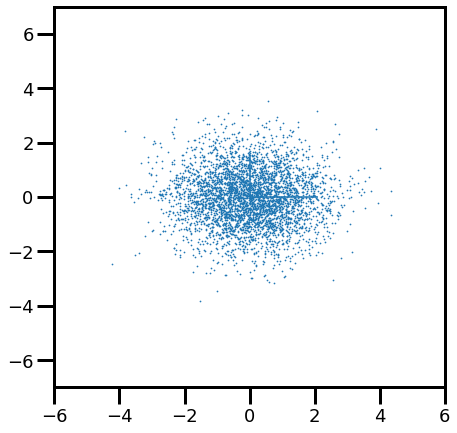

In [83]:
#Using gaussian data to test the ellipticity equation
#generate data
x = np.random.normal(scale=1.2,size=4000)
y = np.random.normal(scale=1.0,size=4000)
z = np.random.normal(scale=1.0,size=1000)
#put data through function
#test_data = np.column_stack((x,y,z))
xy_data = np.column_stack((x,y))
#print(test_data)
#print(axis(xy_data,3))
#Put data through dubinski method
dubinski_test = axis(xy_data,5)
axis_ratio = dubinski_test[0]
semimajor_axis = dubinski_test[1]
semiminor_axis = dubinski_test[0]
#print(axis(test_data,3))
bincounts = 160
np2dhist,bin_edges = np.histogram(x,bins=bincounts)
np2dhist_z,bin_edges_z = np.histogram(y,bins=bincounts)

bin_values = np.array([(bin_edges[i+1]+bin_edges[i])/2 for i in range(len(bin_edges)-1)]) 
bin_values_z = np.array([(bin_edges_z[i+1]+bin_edges_z[i])/2 for i in range(len(bin_edges_z)-1)])
#print(bin_values)
np2d_weighted = np.sum(np2dhist*(bin_values**2))
np2d_weighted_z = np.sum(np2dhist_z*(bin_values_z**2))
ellipticity_zx = max([(1-np.sqrt(((np2d_weighted)/(np2d_weighted_z)))),(1-np.sqrt(((np2d_weighted_z)/(np2d_weighted))))])
actual_ellip = np.sqrt(1-((1.5**2)/(2.1**2)))
dublinski_ellip = np.sqrt(1-((semiminor_axis)**2)/((semimajor_axis)**2))
dub_ellip = np.sqrt(1-(axis_ratio)**2)
#print(max(np.abs(x))**2)
#print(max(np.abs(y))**2)
#print((max(np.abs(y))**2)/(max(np.abs(x))**2))
#print([(1 - np.sqrt(np.sum(np2d_weighted)/np.sum(np2d_weighted_z))),(1 - np.sqrt(np.sum(np2d_weighted_z)/np.sum(np2d_weighted)))])
print('Binned ellipticity (Coral) is:',ellipticity_zx)
print('Naive calculated ellipticity is:',actual_ellip)
#print('Dubinski ellipticity is:',dublinski_ellip)
print('2D Dubinski ellipticity is:',dub_ellip)
#//NOTES- It seems that Dubinski cant quite get to the very small levels of a very circular structure, so Dubinski over
# estimates while Coral seems to underestimate; they both seem to be somewhat sensitive to the amount of particles,
# up to about ~4,000
#Sum up ideas- Dubinski finds the eccentricity of the "core" (the inner dense region), while binning (Coral's method)
#finds the shape of the whole galaxy 

#plotting the data
axwidth = 3
axlength = 12
fontsize=32
fontsizetick = 18
plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

fig = plt.figure(figsize=(7,7))
ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsizetick)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsizetick)
for line in ax.get_xticklines() + ax.get_yticklines():
    line.set_markersize(18)
    line.set_markeredgewidth(3)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsizetick/2)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsizetick/2)

ax.tick_params(which='major',width=axwidth,length=axlength+5)
ax.tick_params(which='minor',width=axwidth,length=axlength)
plt.scatter(x,y,s=0.5)
plt.hlines(0,0,2.1)
plt.vlines(0,0,1.5)
plt.ylim([-7,7])
plt.xlim([-6,6])

plt.show()

In [81]:
bincounts = 100
nphist,bin_edges = np.histogram(x,bins=bincounts)
nphist_z,bin_edges_z = np.histogram(y,bins=bincounts)
peaks, _ = find_peaks(x)
results_half = peak_widths(x, peaks, rel_height=0.5)
results_half[0]  # widths

array([ 0.9972139 ,  1.46507802,  0.87966536,  3.92160928,  1.56444449,
        1.89034521,  1.25513597,  1.18574793,  0.9899735 ,  1.97226651,
        0.85271255,  1.85707689,  2.08647112,  3.4772668 ,  1.5652185 ,
        2.63174777,  1.05975428,  0.78244112,  1.08393697,  1.02910425,
        0.64986541,  2.59398114,  1.2651045 ,  0.83634171,  1.52623919,
        0.6567316 ,  1.68846777,  0.95342085,  2.59350161,  2.81817033,
        0.65192094,  1.9340327 ,  0.70564874,  2.12294833,  1.6006514 ,
        1.05118654,  2.2735755 ,  3.46635765,  0.81046816,  0.66179985,
        1.76570447,  1.22136981,  1.07191853,  0.9523734 ,  1.37004584,
        1.20749819,  2.55868194,  0.89031197,  1.40587785,  3.96892311,
        2.15543357,  0.95759109,  2.55392097,  0.95198166,  0.72249959,
        0.88619638,  2.4882279 ,  1.69137309,  1.1752517 ,  2.00870872,
        0.89525645,  1.59991508,  1.64157576,  0.81665637,  1.53468849,
        1.94559789,  1.184148  ,  1.14606969,  1.07135501,  1.82

In [110]:
#create the function to get the ellipticity (maybe velo?) data
def ellipticities(stellar_file,iter_num):
    host_center = np.loadtxt('./galaxy_center_file.csv',delimiter=',',dtype=object)
    stellar_file = stellar_file
    gal_name = [i[0] for i in host_center if i[0][0:5] in stellar_file[22:27]]
    host_center = [i[1:4] for i in host_center if i[0][0:5] in stellar_file[22:27]]
    print(gal_name)
    h = 0.71
    radii = [7,4,6,2,3,7,4,2,2.5,2,11]
    host_center = np.array([[float(j)*(1000.0/h) for j in i] for i in host_center])
    ellipticities = [calc_ellip(stellar_file,i,radii[points]) for i in host_center]
    return ellipticities 

['m10xa']
7


<ipython-input-131-a3c9d4b5d9bb>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(stellar_file)


Radius: 7
axis ratios:  [0.846808 1.      ]
deviations from previous iteration: 8.2950e-02, 9.1640e-02
number of particles in shell / sphere:  26254
axis ratios:  [0.846808 1.      ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  26254
number of iterations:  2
number of particles in shell / sphere:  26254
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.71708 [-0.95418002  0.29923317]
1.00000 [-0.29923317 -0.95418002]
axis ratios:  [0.846808 1.      ]
Radius: 7
axis ratios:  [0.66742397 1.        ]
deviations from previous iteration: 1.9945e-01, 8.4161e-03
number of particles in shell / sphere:  26254
axis ratios:  [0.66742397 1.        ]
deviations from previous iteration: 7.4099e-17, 0.0000e+00
number of particles in shell / sphere:  26254
number of iterations:  2
number of particles in shell / sphere:  26254
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenv

<ipython-input-131-a3c9d4b5d9bb>:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  vrot_diffs = np.array([cal_rotation(i) for i in np.arange(0,360,10)])


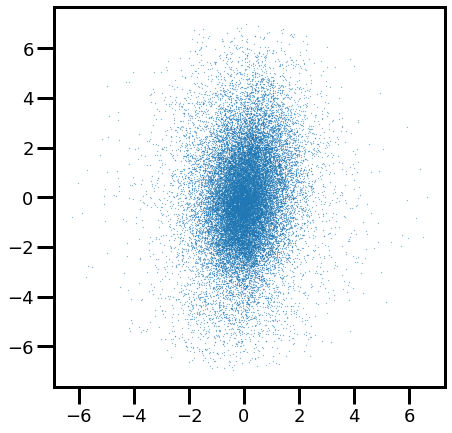

Binned e = 0.5099865872928996
Dubinski ellipticity = 0.7446779489547811
Projection axis is: zx


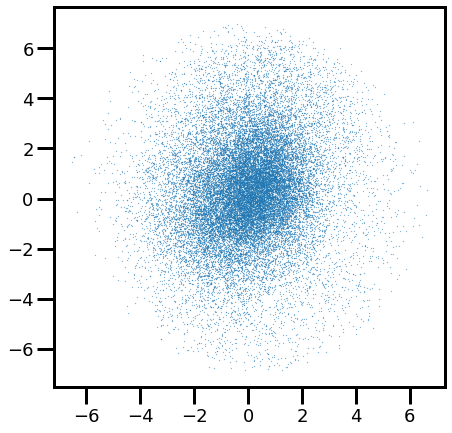

2D Dubinski test for XY: 0.5318986904515195
Second plot is XY projection for 2D test


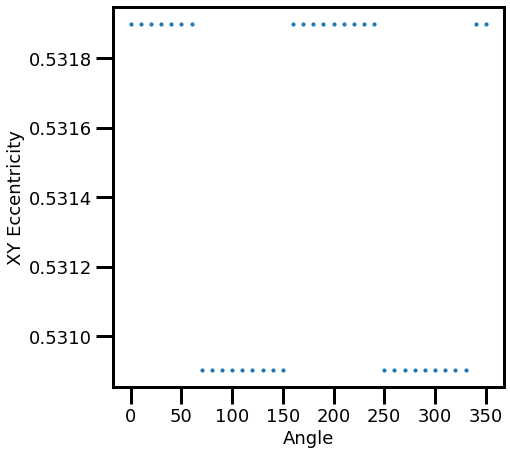

One galaxy done
['m10xb']
4
Radius: 4
axis ratios:  [0.89782764 1.        ]
deviations from previous iteration: 5.3836e-02, 2.6804e-01
number of particles in shell / sphere:  10055
axis ratios:  [0.89782764 1.        ]
deviations from previous iteration: 9.9679e-17, 0.0000e+00
number of particles in shell / sphere:  10055
number of iterations:  2
number of particles in shell / sphere:  10055
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.80609 [-0.86598156  0.50007594]
1.00000 [-0.50007594 -0.86598156]
axis ratios:  [0.89782764 1.        ]
Radius: 4
axis ratios:  [0.76873341 1.        ]
deviations from previous iteration: 1.3075e-01, 3.1573e-01
number of particles in shell / sphere:  10055
axis ratios:  [0.76873341 1.        ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  10055
number of iterations:  2
number of particles in shell / sphere:  10055
normalized eigenvalues (sorted in ascend

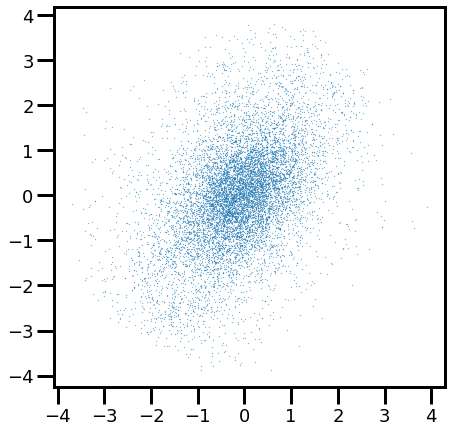

Binned e = 0.20138222923083782
Dubinski ellipticity = 0.6395693406211473
Projection axis is: zx


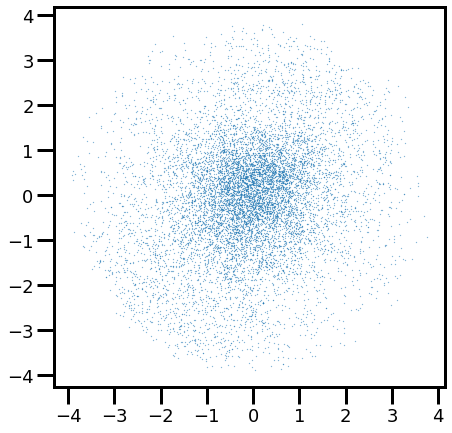

2D Dubinski test for XY: 0.4403470535018258
Second plot is XY projection for 2D test


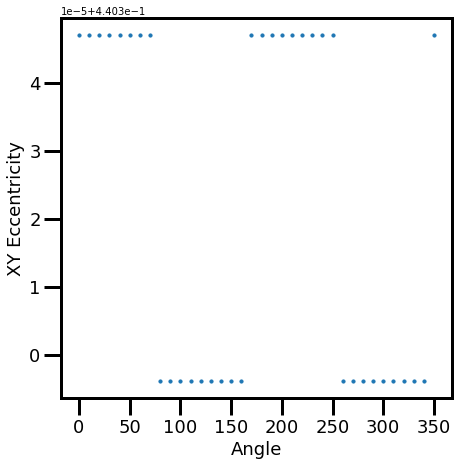

One galaxy done
['m10xc', 'm10xc_A']
6
Radius: 6
axis ratios:  [0.89116799 1.        ]
deviations from previous iteration: 5.7548e-02, 5.5310e-01
number of particles in shell / sphere:  37247
axis ratios:  [0.8914556 1.       ]
deviations from previous iteration: 1.6134e-04, 7.8962e-09
number of particles in shell / sphere:  37211
number of iterations:  2
number of particles in shell / sphere:  37211
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.79469 [-0.69043903  0.72339059]
1.00000 [0.72339059 0.69043903]
axis ratios:  [0.8914556 1.       ]
Radius: 6
axis ratios:  [0.89116799 1.        ]
deviations from previous iteration: 5.7548e-02, 1.2233e-02
number of particles in shell / sphere:  37247
axis ratios:  [0.8914556 1.       ]
deviations from previous iteration: 1.6134e-04, 7.8962e-09
number of particles in shell / sphere:  37211
number of iterations:  2
number of particles in shell / sphere:  37211
normalized eigenvalues (sorted in asc

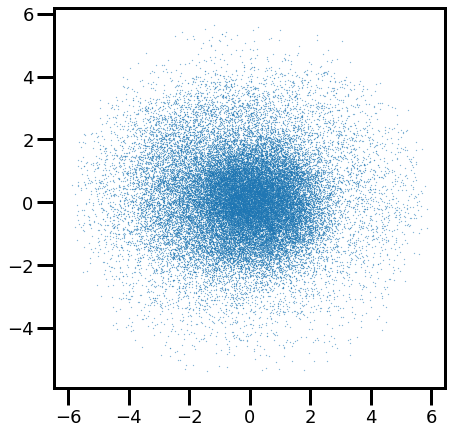

Binned e = 0.1840019675918807
Dubinski ellipticity = 0.45310806287060396
Projection axis is: xy


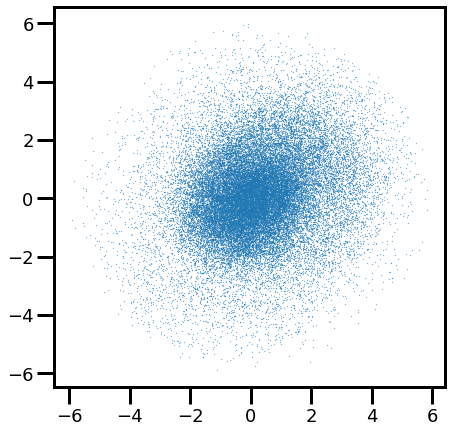

2D Dubinski test for XY: 0.4531080628706282
Second plot is XY projection for 2D test


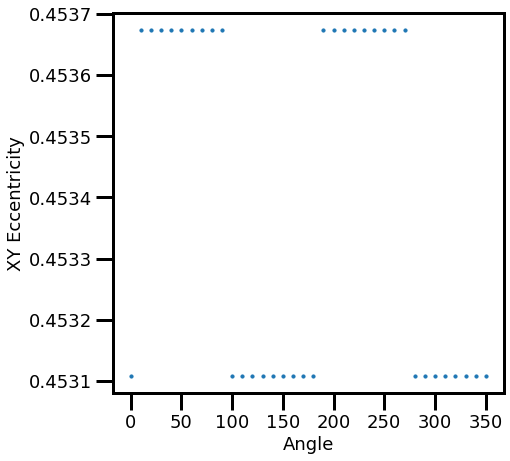

One galaxy done
2
Radius: 2
axis ratios:  [0.8841125 1.       ]
deviations from previous iteration: 6.1508e-02, 2.2483e-01
number of particles in shell / sphere:  2129
axis ratios:  [0.8841125 1.       ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  2129
number of iterations:  2
number of particles in shell / sphere:  2129
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.78165 [-0.88758663 -0.46064084]
1.00000 [ 0.46064084 -0.88758663]
axis ratios:  [0.8841125 1.       ]
Radius: 2
axis ratios:  [0.8841125 1.       ]
deviations from previous iteration: 6.1508e-02, 2.0140e-03
number of particles in shell / sphere:  2129
axis ratios:  [0.8841125 1.       ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  2129
number of iterations:  2
number of particles in shell / sphere:  2129
normalized eigenvalues (sorted in ascending order) and correspondi

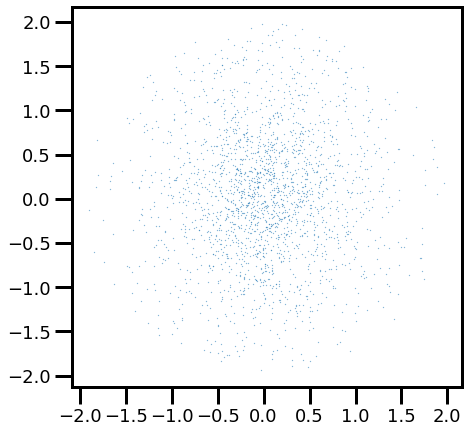

Binned e = 0.1860390919951238
Dubinski ellipticity = 0.4672741104821032
Projection axis is: xy


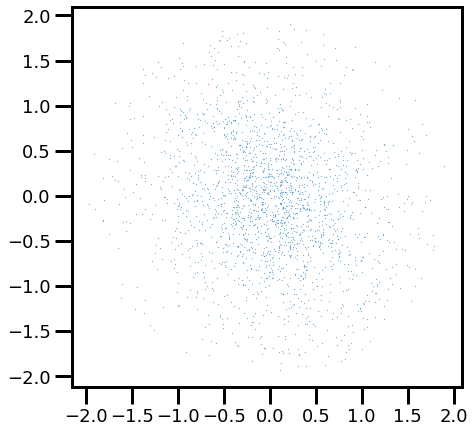

2D Dubinski test for XY: 0.46727411048215395
Second plot is XY projection for 2D test


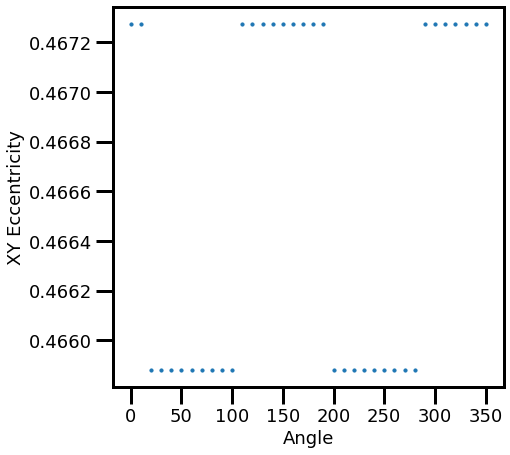

One galaxy done
['m10xd_A', 'm10xd']
3
Radius: 3
axis ratios:  [0.7577226 1.       ]
deviations from previous iteration: 1.3784e-01, 3.3910e-02
number of particles in shell / sphere:  4098
axis ratios:  [0.76114429 1.        ]
deviations from previous iteration: 2.2528e-03, 4.3416e-05
number of particles in shell / sphere:  4041
number of iterations:  2
number of particles in shell / sphere:  4041
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.57934 [-0.1898375   0.98181552]
1.00000 [0.98181552 0.1898375 ]
axis ratios:  [0.76114429 1.        ]
Radius: 3
axis ratios:  [0.70115668 1.        ]
deviations from previous iteration: 1.7567e-01, 1.4426e-02
number of particles in shell / sphere:  4098
axis ratios:  [0.70115668 1.        ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  4098
number of iterations:  2
number of particles in shell / sphere:  4098
normalized eigenvalues (sorted in ascen

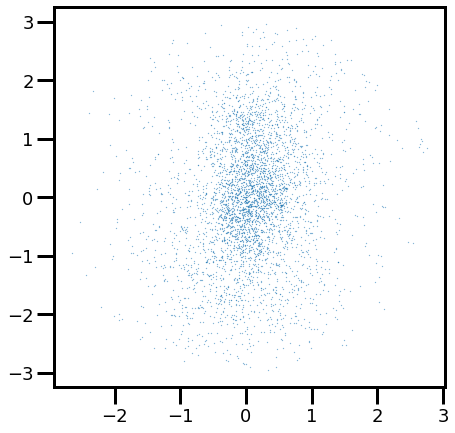

Binned e = 0.40996996602472224
Dubinski ellipticity = 0.7130072269956905
Projection axis is: zx


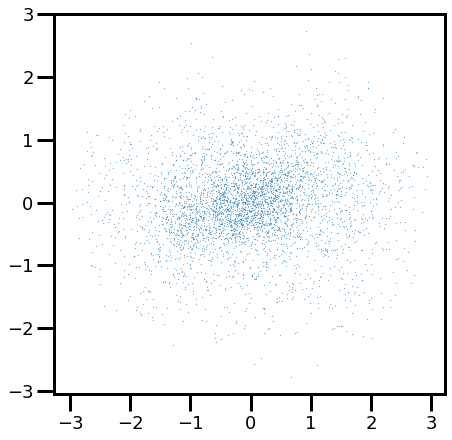

2D Dubinski test for XY: 0.6485825905001006
Second plot is XY projection for 2D test


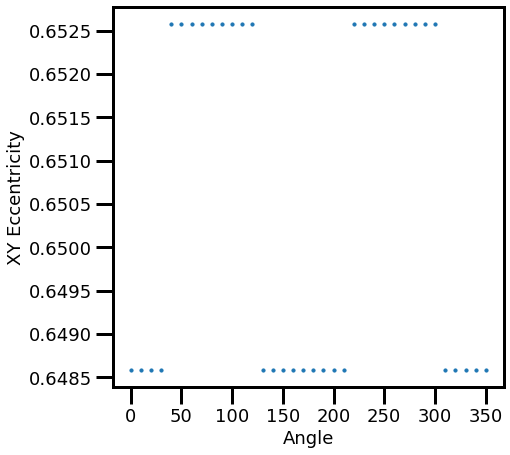

One galaxy done
7
Radius: 7
axis ratios:  [0.89018696 1.        ]
deviations from previous iteration: 5.8096e-02, 8.3411e-03
number of particles in shell / sphere:  21498
axis ratios:  [0.89010749 1.        ]
deviations from previous iteration: 4.4636e-05, 1.7541e-07
number of particles in shell / sphere:  21483
number of iterations:  2
number of particles in shell / sphere:  21483
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.79229 [0.09165145 0.99579115]
1.00000 [ 0.99579115 -0.09165145]
axis ratios:  [0.89010749 1.        ]
Radius: 7
axis ratios:  [0.89018696 1.        ]
deviations from previous iteration: 5.8096e-02, 1.9086e-01
number of particles in shell / sphere:  21498
axis ratios:  [0.89018696 1.        ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  21498
number of iterations:  2
number of particles in shell / sphere:  21498
normalized eigenvalues (sorted in ascending order) a

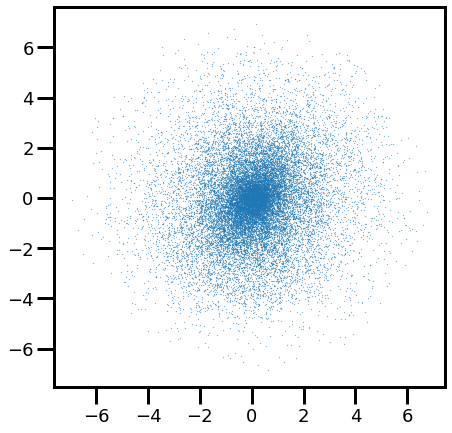

Binned e = 0.08275160243621149
Dubinski ellipticity = 0.4555954130055719
Projection axis is: xy


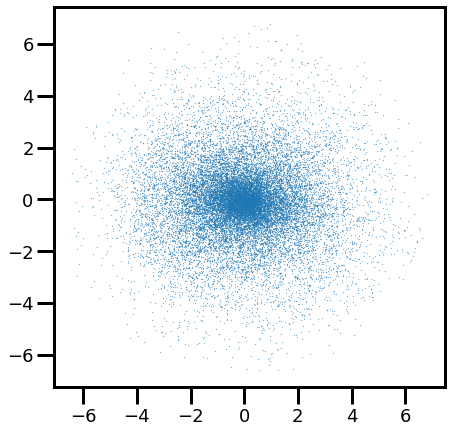

2D Dubinski test for XY: 0.45575064685528316
Second plot is XY projection for 2D test


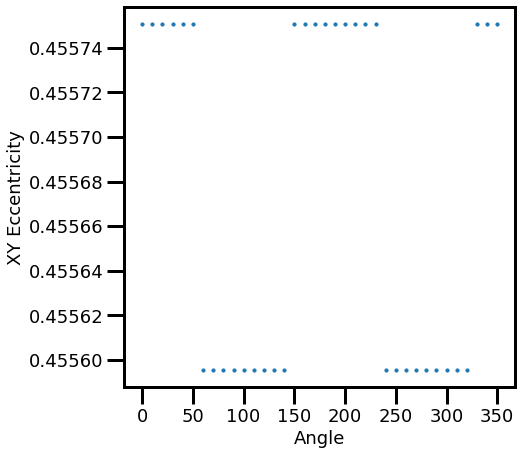

One galaxy done
['m10xe_C', 'm10xe_D', 'm10xe_B', 'm10xe_A', 'm10xe']
4
Radius: 4
axis ratios:  [0.9046836 1.       ]
deviations from previous iteration: 5.0043e-02, 3.2203e-01
number of particles in shell / sphere:  5214
axis ratios:  [0.90535079 1.        ]
deviations from previous iteration: 3.6861e-04, 2.8408e-05
number of particles in shell / sphere:  5196
number of iterations:  2
number of particles in shell / sphere:  5196
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.81966 [0.53967138 0.84187577]
1.00000 [ 0.84187577 -0.53967138]
axis ratios:  [0.90535079 1.        ]
Radius: 4
axis ratios:  [0.73400449 1.        ]
deviations from previous iteration: 1.5340e-01, 2.7595e-01
number of particles in shell / sphere:  5214
axis ratios:  [0.74183499 1.        ]
deviations from previous iteration: 5.3058e-03, 3.1268e-06
number of particles in shell / sphere:  5086
number of iterations:  2
number of particles in shell / sphere:  5086
normal

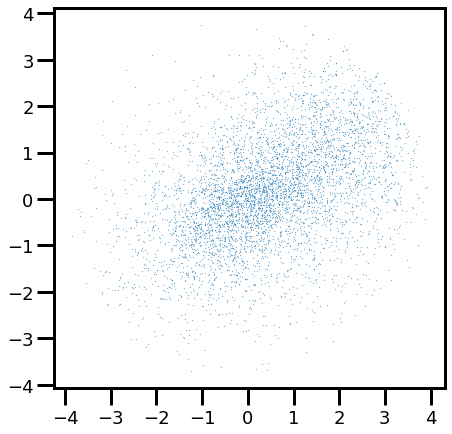

Binned e = 0.2013808838788772
Dubinski ellipticity = 0.6705824648715178
Projection axis is: yz


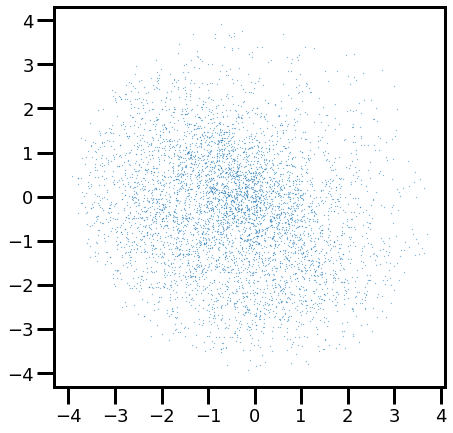

2D Dubinski test for XY: 0.4246645128450625
Second plot is XY projection for 2D test


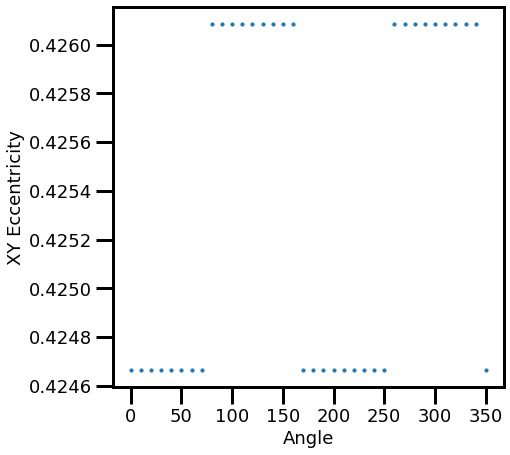

One galaxy done
2
Radius: 2
axis ratios:  [0.82766581 1.        ]
deviations from previous iteration: 9.4292e-02, 1.2970e-03
number of particles in shell / sphere:  1027
axis ratios:  [0.82835954 1.        ]
deviations from previous iteration: 4.1891e-04, 9.0772e-06
number of particles in shell / sphere:  1023
number of iterations:  2
number of particles in shell / sphere:  1023
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.68618 [0.0329965  0.99945547]
1.00000 [ 0.99945547 -0.0329965 ]
axis ratios:  [0.82835954 1.        ]
Radius: 2
axis ratios:  [0.79688993 1.        ]
deviations from previous iteration: 1.1303e-01, 2.4503e-01
number of particles in shell / sphere:  1027
axis ratios:  [0.79688993 1.        ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  1027
number of iterations:  2
number of particles in shell / sphere:  1027
normalized eigenvalues (sorted in ascending order) and cor

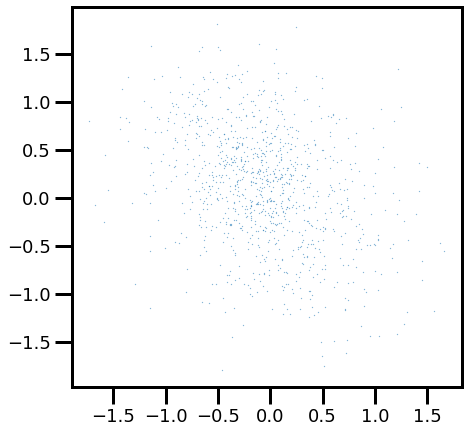

Binned e = 0.12161053921339493
Dubinski ellipticity = 0.6041245203342016
Projection axis is: yz


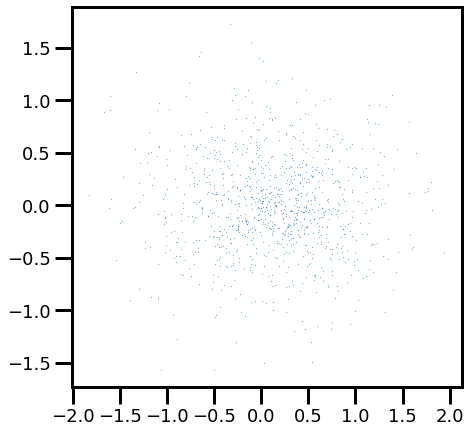

2D Dubinski test for XY: 0.5601968172426244
Second plot is XY projection for 2D test


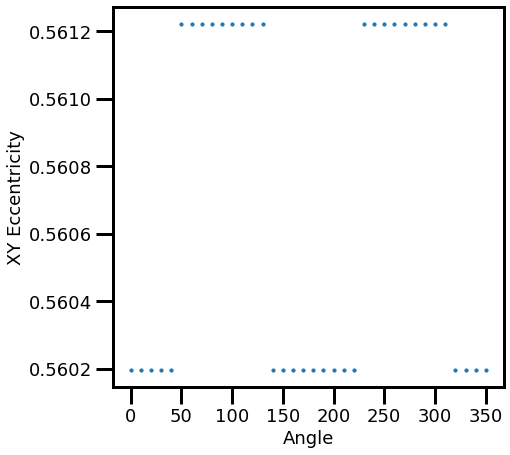

One galaxy done
2.5
Radius: 2.5
axis ratios:  [0.98565512 1.        ]
deviations from previous iteration: 7.2243e-03, 8.2298e-02
number of particles in shell / sphere:  3368
axis ratios:  [0.98565512 1.        ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  3368
number of iterations:  2
number of particles in shell / sphere:  3368
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.97152 [-0.95885107 -0.28390955]
1.00000 [ 0.28390955 -0.95885107]
axis ratios:  [0.98565512 1.        ]
Radius: 2.5
axis ratios:  [0.98565512 1.        ]
deviations from previous iteration: 7.2243e-03, 1.6597e-01
number of particles in shell / sphere:  3368
axis ratios:  [0.98565512 1.        ]
deviations from previous iteration: 0.0000e+00, 0.0000e+00
number of particles in shell / sphere:  3368
number of iterations:  2
number of particles in shell / sphere:  3368
normalized eigenvalues (sorted in ascending order)

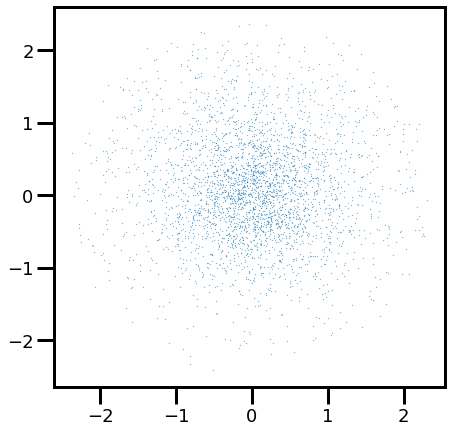

Binned e = 0.041966450070973216
Dubinski ellipticity = 0.16877200025608727
Projection axis is: xy


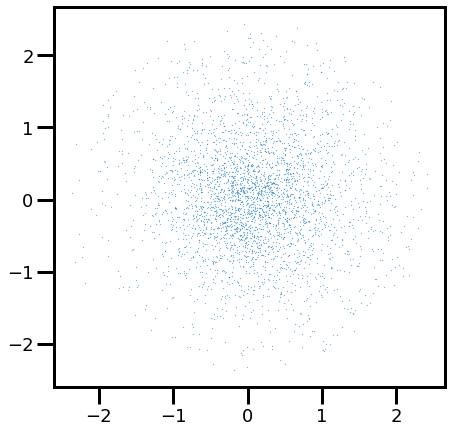

2D Dubinski test for XY: 0.16877200025571035
Second plot is XY projection for 2D test


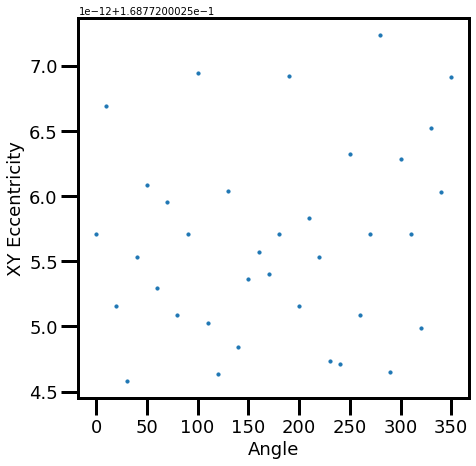

One galaxy done
2
Radius: 2
axis ratios:  [0.87407891 1.        ]
deviations from previous iteration: 6.7191e-02, 3.7253e-04
number of particles in shell / sphere:  1093
axis ratios:  [0.87700646 1.        ]
deviations from previous iteration: 1.6718e-03, 2.4697e-05
number of particles in shell / sphere:  1086
number of iterations:  2
number of particles in shell / sphere:  1086
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.76914 [-0.01433124  0.9998973 ]
1.00000 [0.9998973  0.01433124]
axis ratios:  [0.87700646 1.        ]
Radius: 2
axis ratios:  [0.87407891 1.        ]
deviations from previous iteration: 6.7191e-02, 3.7454e-02
number of particles in shell / sphere:  1093
axis ratios:  [0.87407891 1.        ]
deviations from previous iteration: 9.7042e-17, 0.0000e+00
number of particles in shell / sphere:  1093
number of iterations:  2
number of particles in shell / sphere:  1093
normalized eigenvalues (sorted in ascending order) and cor

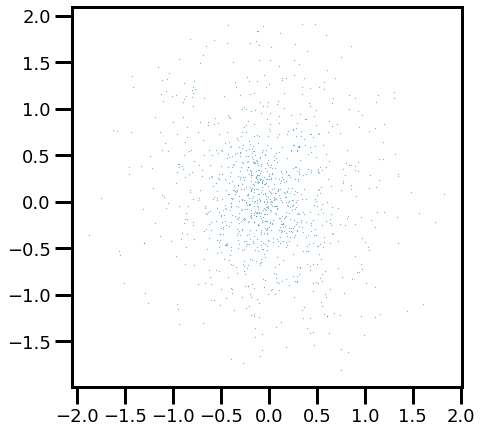

Binned e = 0.1960129974702972
Dubinski ellipticity = 0.48578395845134437
Projection axis is: xy


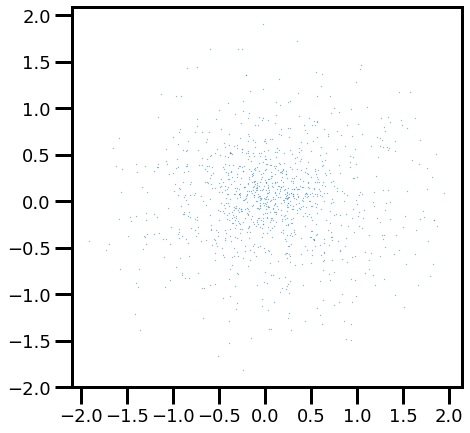

2D Dubinski test for XY: 0.48047858380475467
Second plot is XY projection for 2D test


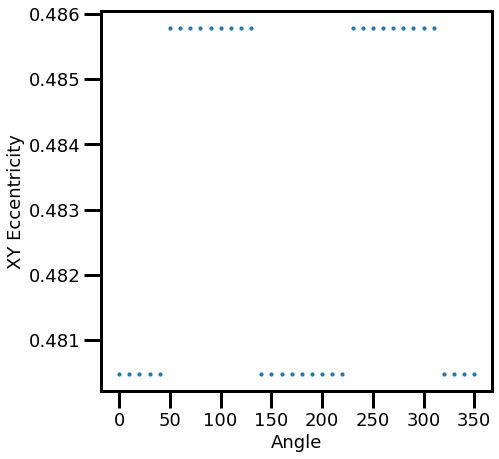

One galaxy done
11
Radius: 11
axis ratios:  [0.72649785 1.        ]
deviations from previous iteration: 1.5841e-01, 5.2196e-01
number of particles in shell / sphere:  116029
axis ratios:  [0.72823562 1.        ]
deviations from previous iteration: 1.1946e-03, 9.1224e-06
number of particles in shell / sphere:  115152
number of iterations:  2
number of particles in shell / sphere:  115152
normalized eigenvalues (sorted in ascending order) and corresponding unit eigenvectors are:
0.53033 [0.67144963 0.74105019]
1.00000 [ 0.74105019 -0.67144963]
axis ratios:  [0.72823562 1.        ]
Radius: 11
axis ratios:  [0.73546706 1.        ]
deviations from previous iteration: 1.5243e-01, 8.0058e-02
number of particles in shell / sphere:  116029
axis ratios:  [0.73694901 1.        ]
deviations from previous iteration: 1.0065e-03, 2.1439e-06
number of particles in shell / sphere:  115462
number of iterations:  2
number of particles in shell / sphere:  115462
normalized eigenvalues (sorted in ascending

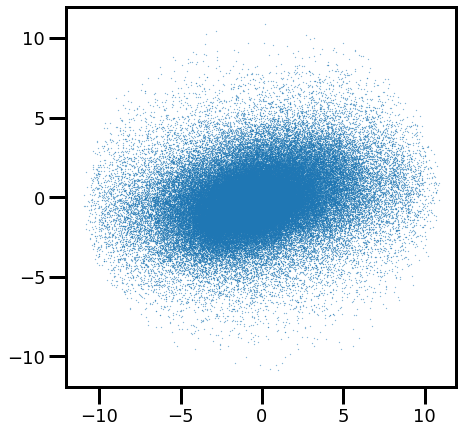

Binned e = 0.37608994980517196
Dubinski ellipticity = 0.6759483421892933
Projection axis is: zx


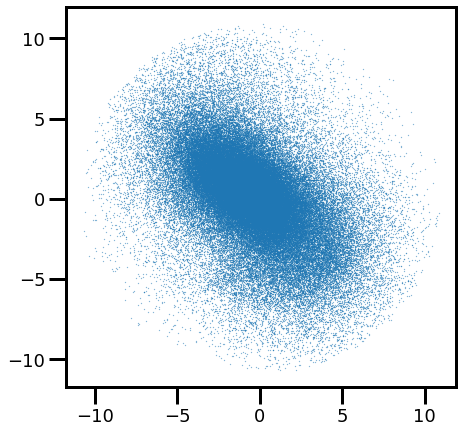

2D Dubinski test for XY: 0.6853268432726997
Second plot is XY projection for 2D test


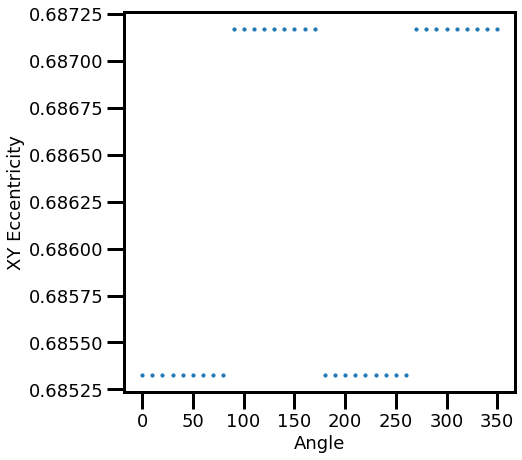

One galaxy done


In [132]:
#calculate the ellipticities 
points = 0 
h = 0.71

fire_ellipticiites = [ellipticities(i,j) for j,i in enumerate(glob.glob('./star_files/*.hdf5'))]


[]

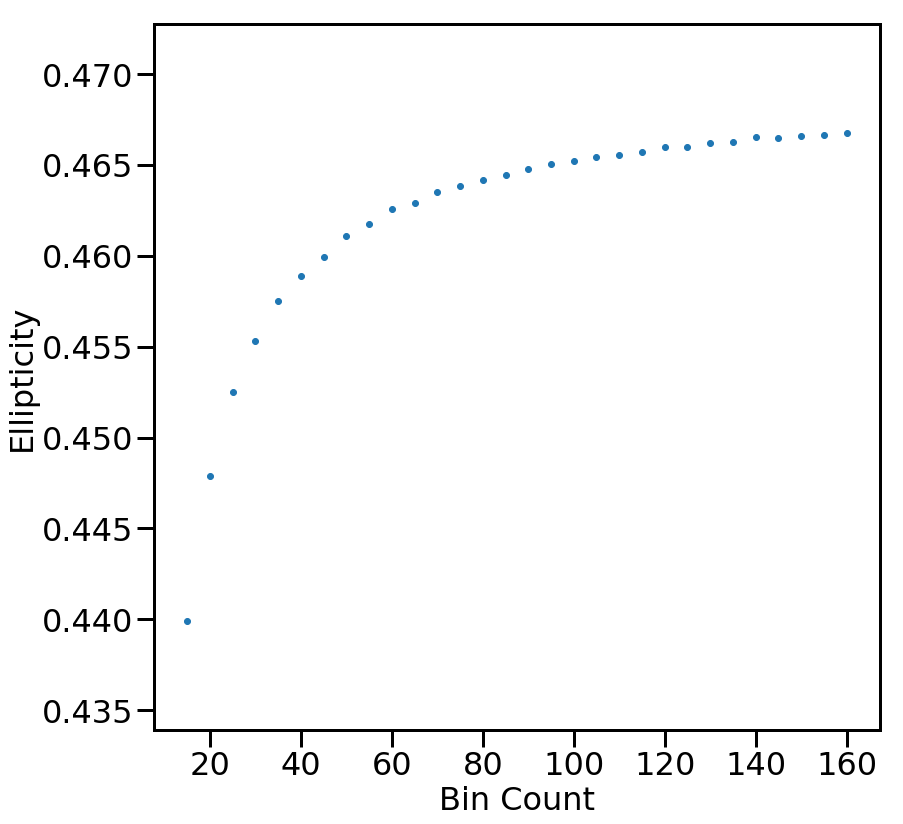

In [330]:
#bin count vs ellipticity plot
ellip_change = [0.4399041546688295,0.44788568330134093,0.4524787874214887,0.4553080726636807,0.4575097246768216,0.458892616205562,0.4599187796885206,0.4610695339492433,0.46172646410181517,0.46255071274586146,0.4629271756225659,0.46353002797721254,0.46383347536988906,0.4641949496420221,0.4644419946810532,0.46480189642715164,0.46503844128632754,0.4651930321471903,0.4654392239718961,0.4655198726215819,0.465728745534601,0.4659590521785909,0.4660044107200021,0.46619261341731255,0.46626790980950417,0.4665284552305534,0.46649903319185615,0.466564547694271,0.4666698738592291,0.4667616538825242]
bin_count = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160]
axwidth = 3
axlength = 12
fontsize=32

plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

fig = plt.figure(figsize=(13,13))
ax = plt.gca()
datax = bin_count
datay = ellip_change


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for line in ax.get_xticklines() + ax.get_yticklines():
    line.set_markersize(18)
    line.set_markeredgewidth(3)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)

ax.tick_params(which='major',width=axwidth,length=axlength+5)
ax.tick_params(which='minor',width=axwidth,length=axlength)


plt.scatter(bin_count,ellip_change)
ax.set_ylabel('Ellipticity',fontsize=32)
ax.set_xlabel('Bin Count',fontsize=32)
plt.savefig('Bin Count vs Ellipticity (m10xa)',overwrite=True)
plt.plot()

[]

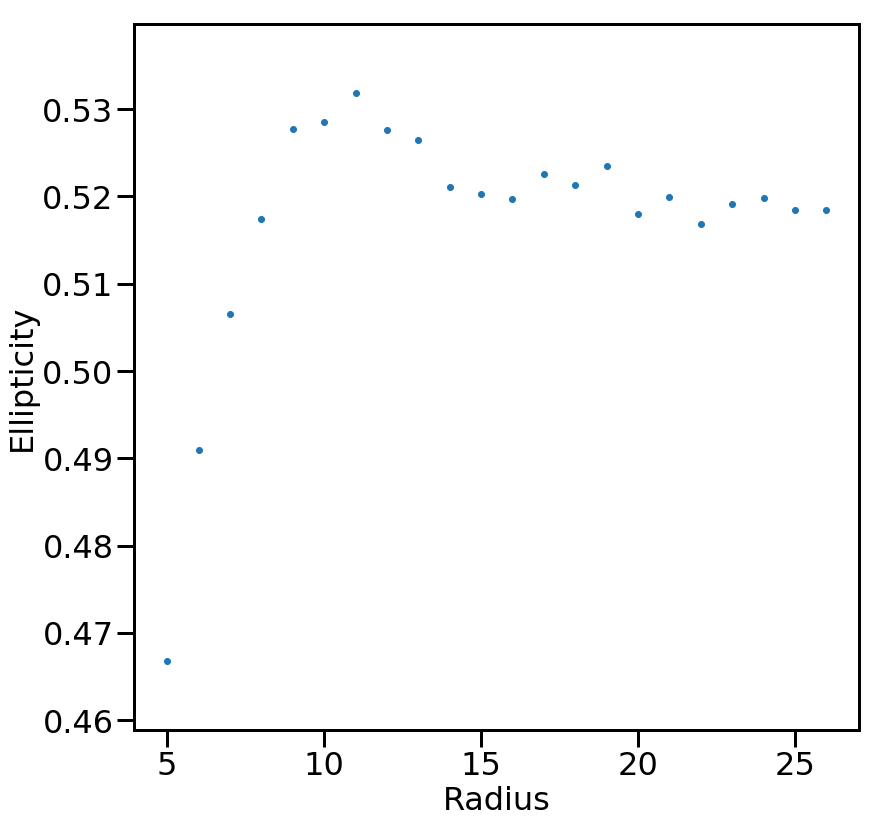

In [376]:
#radius function
ellip_changes_r = [0.4667616538825242,0.4909187296108931,0.5065616207671304,0.5173976774753622,0.5277737992587588,0.5284734900456247,0.531870211405403,0.5275669004258662,0.5264620579769141,0.5211199604595164,0.5202718102816073,0.5196675803728532,0.5225872562044303,0.5212956919051861,0.5234530661799104,0.5179896697596251,0.5198778925967575,0.5168492686979186,0.5191371823942146,0.5197840314821878,0.5184221973015921,0.5184652212738279]
radiuss = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
axwidth = 3
axlength = 12
fontsize=32

plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

fig = plt.figure(figsize=(13,13))
ax = plt.gca()
datax = bin_count
datay = ellip_change


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for line in ax.get_xticklines() + ax.get_yticklines():
    line.set_markersize(18)
    line.set_markeredgewidth(3)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)

ax.tick_params(which='major',width=axwidth,length=axlength+5)
ax.tick_params(which='minor',width=axwidth,length=axlength)


plt.scatter(radiuss,ellip_changes_r)
ax.set_ylabel('Ellipticity',fontsize=32)
ax.set_xlabel('Radius',fontsize=32)
#plt.savefig('Bin Count vs Ellipticity (m10xa)',overwrite=True)
plt.plot()

In [3]:
#test the function
test_plort = velocities_mass('./star_files/snapshot_m10xa_152.stars.hdf5')
print(test_plort)

[array(['8.8481', '11.0268', '13.8447'], dtype=object)]
['m10xa']
What is the galaxy radius?: 2000
it went through
[-1281849.64525973  3791558.94440015 -4449992.30632183]
[-1281849.64525973  3791558.94440015 -4449992.30632183]
The rotational velocity is -4.0096320694 km/s
Velocity dispersion is 17.117417892 km/s
V/sigma = -0.234242810142
The mass of the galaxy (out to 2000.0 pc) = 8.06000079975 log(m*)
('The report for these galaxies: ', [(-4.009632069400547, 17.117417892016476, -0.23424281014198003, 8.060000799748304)])
([(-4.009632069400547, 17.117417892016476, -0.23424281014198003, 8.060000799748304)], ['m10xa'])


In [4]:
velocities_and_masses = [velocities_mass(i) for i in glob.glob('./star_files/*.hdf5')]
#print(glob.glob('./star_files/*.hdf5'))
radii = [2230,1730,2250,1240,1380,2600,2110,2430,1310,900,2930]

[array(['8.8481', '11.0268', '13.8447'], dtype=object)]
['m10xa']
What is the galaxy radius?: 2230
[ 1589550.83505648 -6056729.28248019 -8528714.15192245]
[ 1589550.83505648 -6056729.28248019 -8528714.15192245]
The rotational velocity is 1.31157713304 km/s
Velocity dispersion is 31.2770709551 km/s
V/sigma = 0.0419341419445
The mass of the galaxy (out to 2230.0 pc) = 8.71182688108 log(m*)
('The report for these galaxies: ', [(1.3115771330376123, 31.27707095507042, 0.04193414194448373, 8.711826881080473)])
[array(['9.7768', '12.5925', '10.4034'], dtype=object)]
['m10xb']
What is the galaxy radius?: 1730
[ -90286.24472892  -13765.19715798 -268387.37622704]
[ -90286.24472892  -13765.19715798 -268387.37622704]
The rotational velocity is -0.0222737985762 km/s
Velocity dispersion is 11.2458253467 km/s
V/sigma = -0.00198062817885
The mass of the galaxy (out to 1730.0 pc) = 7.5316752382 log(m*)
('The report for these galaxies: ', [(-0.022273798576170633, 11.245825346716057, -0.00198062817885348

print(velocities_and_masses[2]) 
vrot_sigma = [i[i.index(j)][2] for i in velocities_and_masses for j in i] 
masses = [i[i.index(j)][3] for i in velocities_and_masses for j in i] 
print(masses) 
print(vrot_sigma[0]) 
print(int(max(masses))) 
print([i for i in range(int(max(masses)))]) 
print([i for i in range(int(max(vrot_sigma)))])

In [15]:
masses = [i[0][j][3] for i in velocities_and_masses for j in range(len(i[0]))]
print(masses)
vrot_sigma = [i[0][j][2] for i in velocities_and_masses for j in range(len(i[0]))]
print(vrot_sigma)

[8.711826881080473, 7.531675238199559, 8.150739863575101, 8.132754790636932, 9.061516167954172, 9.1172375601962, 8.660010478904123, 8.66144835691966, 8.6049623929036, 8.602746051681, 8.888978193205016]
[0.04193414194448373, -0.001980628178853489, 0.16511786102135706, 0.06650196102981748, 0.12028013912276535, 0.27623845933537466, 0.11062958741695877, 0.04688558949889462, 0.05570357588466211, 0.09374616724811335, 0.12037288292793195]


In [26]:
print(velocities_and_masses)
complete_data = np.vstack((np.array([i[1][j] for i in velocities_and_masses for j in range(len(i[1]))]),np.array([i[0][j][0] for i in velocities_and_masses for j in range(len(i[0]))])))
complete_data = np.vstack((complete_data,np.array([i[0][j][0] for i in velocities_and_masses for j in range(len(i[0]))])))
complete_data = np.vstack((complete_data,np.array([i[0][j][1] for i in velocities_and_masses for j in range(len(i[0]))])))
#complete_data = np.append(complete_data,[i[1][j] for i in velocities_and_masses for j in range(len(i[1]))])
#complete_data = np.append(complete_data,[i[0][j][0] for i in velocities_and_masses for j in range(len(i[0]))])
# complete_data = np.append(complete_data,[i[0][j][1] for i in velocities_and_masses for j in range(len(i[0]))]])
# complete_data = np.append(complete_data,[i[0][j][2] for i in velocities_and_masses for j in range(len(i[0]))]])
print(complete_data[3])
#complete_data = complete_data.astype('float64')
fmt = '%s '
#np.savetxt('VsigmaData.csv', complete_data, delimiter=',',fmt=fmt)

[([(1.3115771330376123, 31.27707095507042, 0.04193414194448373, 8.711826881080473)], ['m10xa']), ([(-0.022273798576170633, 11.245825346716057, -0.001980628178853489, 7.531675238199559)], ['m10xb']), ([(3.2270526774923787, 19.543934602416982, 0.16511786102135706, 8.150739863575101), (1.0408165539494885, 15.650915218617653, 0.06650196102981748, 8.132754790636932)], ['m10xc', 'm10xc_A']), ([(2.416342997286603, 20.08929333562155, 0.12028013912276535, 9.061516167954172), (5.642849757000951, 20.42745883602724, 0.27623845933537466, 9.1172375601962)], ['m10xd_A', 'm10xd']), ([(2.149638599578473, 19.43095558583768, 0.11062958741695877, 8.660010478904123), (0.920202432571221, 19.62655140750477, 0.04688558949889462, 8.66144835691966), (1.012905868657097, 18.18385718637498, 0.05570357588466211, 8.6049623929036), (1.6963027185829642, 18.094635422197513, 0.09374616724811335, 8.602746051681), (2.9874900600141365, 24.818630137842312, 0.12037288292793195, 8.888978193205016)], ['m10xe_C', 'm10xe_D', 'm1

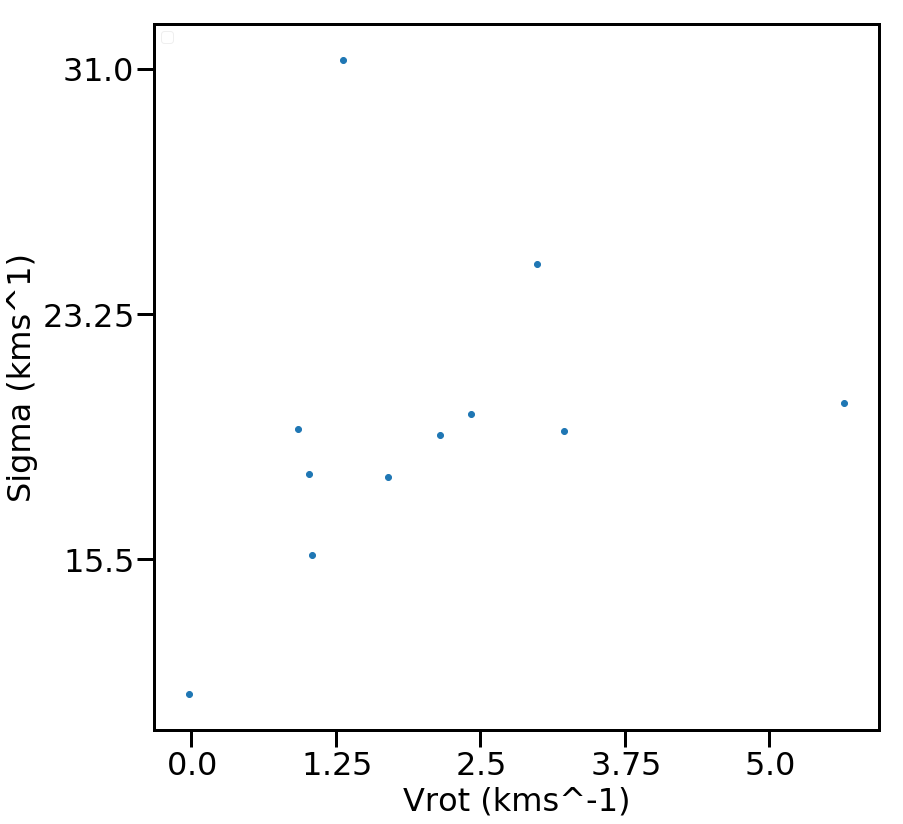

In [30]:
axwidth = 3
axlength = 12
fontsize=32

plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

fig = plt.figure(figsize=(13,13))
ax = plt.gca()
#<do plotting>
datax = np.array([i[0][j][0] for i in velocities_and_masses for j in range(len(i[0]))])
datay = np.array([i[0][j][1] for i in velocities_and_masses for j in range(len(i[0]))])

xtickloc = np.linspace(0,int(float(max(datax))),5)
xtickstr = ['$'+str(kk)+'$' for kk in xtickloc]
ytickloc = np.linspace(0,int(float(max(datay))),5)
ytickstr = ['$'+str(kk)+'$' for kk in ytickloc]

plt.xticks(xtickloc,xtickstr)
plt.yticks(ytickloc,ytickstr)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for line in ax.get_xticklines() + ax.get_yticklines():
    line.set_markersize(18)
    line.set_markeredgewidth(3)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)

ax.tick_params(which='major',width=axwidth,length=axlength+5)
ax.tick_params(which='minor',width=axwidth,length=axlength)

plt.scatter(datax,datay)

ax.set_xlabel('Vrot (kms^-1)',fontsize=32)
ax.set_ylabel('Sigma (kms^1)',fontsize=32)
ax.legend(fontsize=15,loc='upper left',framealpha=0.3)
#plt.savefig("FIRE_MassvsVrot.pdf",overwrite=True)
plt.show()

In [8]:
f = (h5py.File('./snapshot_m10xa_152.stars.hdf5'))
print(f['PartType4'])

<HDF5 group "/PartType4" (9 members)>


In [18]:
# data_path = 'WheelerData.csv'
# with open(data_path, 'r') as f:
#     reader = csv.reader(f, delimiter=',')
#     headers = next(reader)
#     data = np.array(list(reader)).astype(float)
data = np.genfromtxt('wpd_datasets.csv',delimiter=",",skip_header=2,usecols=(0,1,2,3,4,5))
additional_data = np.genfromtxt('wheelerdata.csv',delimiter=',',usecols=(0,5,6))

wheeler_masses_sim = (data[0:12,0])
wheeler_velos_sim = data[0:12,1]
wheeler_masses_obs_sat = (data[0:29,2])
wheeler_velos_obs_sat = data[0:29,3]
wheeler_masses_obs_iso = (data[0:10,4])
wheeler_velos_obs_iso = data[0:10,5]
allmasses = np.log10(additional_data[:,0]*1e6)
allvelos = additional_data[:,1]
table_masses = np.array([i for i in allmasses if i>6])
table_velos = np.array([allvelos[np.where(allmasses==i)[0][0]] for i in table_masses])
#print([np.where(allmasses ==i)[0][0] for i in table_masses])

print(len(table_masses))
print(len(table_velos))
print(table_velos)
print(10**(table_masses)/1e6)
print(table_masses)
#print(len(masses))
print(len(wheeler_masses_sim))
print(len(wheeler_masses_obs_sat))
print(len(wheeler_masses_obs_iso))
print(len(allmasses))
#print(wheeler_masses_sim)

newmasses = np.append(np.append(np.append(np.append(masses,wheeler_masses_sim),wheeler_masses_obs_sat),wheeler_masses_obs_iso),table_masses)
newvelos = np.append(np.append(np.append(np.append(vrot_sigma,wheeler_velos_sim),wheeler_velos_obs_sat),wheeler_velos_obs_iso),table_velos)

print(len(newmasses))
print(len(newvelos))
print(max(newmasses))
print(min(newvelos))
#print(newmasses)

20
20
[0.25 0.13 1.43 0.47 0.04 0.48 0.48 0.41 1.99 1.43 0.56 1.01 1.7  0.02
 0.96 0.45 0.16 0.28 0.16 0.03]
[  3.98     6.3      7.6      9.5      2.8      3.9    100.     100.0001
   6.       6.61     8.3     43.       1.6      2.6     62.     187.
   2.3      3.5      5.5     20.    ]
[6.59988307 6.79934055 6.88081359 6.97772361 6.44715803 6.59106461
 8.         8.00000043 6.77815125 6.82020146 6.91907809 7.63346846
 6.20411998 6.41497335 7.79239169 8.27184161 6.36172784 6.54406804
 6.74036269 7.30103   ]
12
29
10
40
82
82
9.1172375601962
-0.001980628178853489


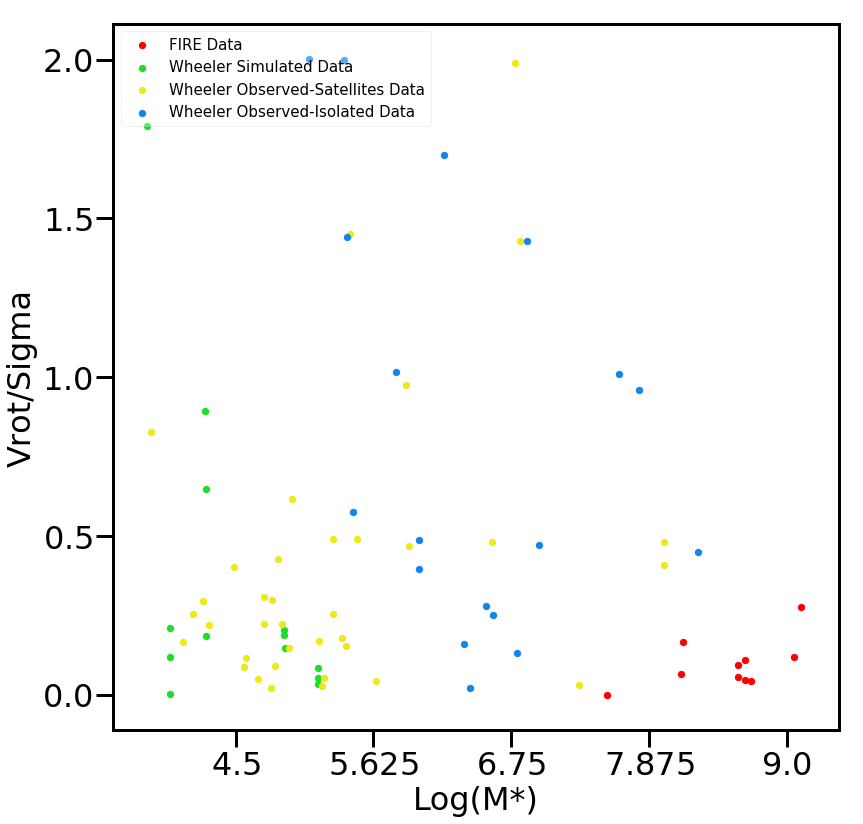

In [19]:
axwidth = 3
axlength = 12
fontsize=32

plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

fig = plt.figure(figsize=(13,13))
ax = plt.gca()
#<do plotting>
datax = newmasses
datay = newvelos

xtickloc = np.linspace(0,int(max(datax)),9)
xtickstr = ['$'+str(kk)+'$' for kk in xtickloc]
ytickloc = np.linspace(0,int(max(datay)),5)
ytickstr = ['$'+str(kk)+'$' for kk in ytickloc]

plt.xticks(xtickloc,xtickstr)
plt.yticks(ytickloc,ytickstr)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for line in ax.get_xticklines() + ax.get_yticklines():
    line.set_markersize(18)
    line.set_markeredgewidth(3)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)

ax.tick_params(which='major',width=axwidth,length=axlength+5)
ax.tick_params(which='minor',width=axwidth,length=axlength)

plt.scatter(datax[0:10],datay[0:10],c='r',label='FIRE Data',s=40)
plt.scatter([datax[11:24]],[datay[11:24]],c='#1bde28',label='Wheeler Simulated Data',s=40)
plt.scatter(datax[67:72],datay[67:72],c='#edea18',s=40)
plt.scatter([datax[25:55]],[datay[25:55]],c='#edea18',label='Wheeler Observed-Satellites Data',s=40)
plt.scatter(datax[81:86],datay[81:86],c='#edea18',s=40)
plt.scatter(datax[55:66],datay[55:66],c='#1384ed',label='Wheeler Observed-Isolated Data',s=40)
plt.scatter(datax[73:80],datay[73:80],c='#1384ed',s=40)
#plt.scatter(datax[67:87],datay[67:87],c='#40e2ed',label='Wheeler Observed-Extended Data',s=40)
ax.set_xlabel('Log(M*)',fontsize=32)
ax.set_ylabel('Vrot/Sigma',fontsize=32)
ax.legend(fontsize=15,loc='upper left',framealpha=0.3)
plt.savefig("FIRE_MassvsVrot.pdf",overwrite=True)
plt.show()



In [51]:
#ellipticity relationship
ellipticity_data = np.genfromtxt('wheeler_ellipticity.csv',delimiter=",",skip_header=2,usecols=(0,1,2,3,4,5))


wheeler_ellips_sate = ellipticity_data[0:29,0]
wheeler_ellips_sate_velo = ellipticity_data[0:29,1] 
wheeler_ellips_iso = ellipticity_data[0:10,2]
wheeler_ellips_iso_velo = ellipticity_data[0:10,3]
wheeler_ellips_sim = ellipticity_data[0:12,4]
wheeler_ellips_sim_velo = ellipticity_data[0:12,5]
allellips = additional_data[:,2]
table_ellips = np.array([i for i in allellips if i>0.8])
table_ellips_velo = np.array([allvelos[np.where(allellips==i)[0][0]] for i in table_ellips])

#print(wheeler_ellips_sate)
#print(wheeler_ellips_sate_velo)
#print(wheeler_ellips_iso)
#print(wheeler_ellips_iso_velo)
#print(wheeler_ellips_sim)
#print(wheeler_ellips_sim_velo)

ellip_data = np.hstack((wheeler_ellips_sate,wheeler_ellips_iso,wheeler_ellips_sim,table_ellips))
ellip_velo_data = np.hstack((wheeler_ellips_sate_velo,wheeler_ellips_iso_velo,wheeler_ellips_sim_velo,table_ellips_velo))
print(len(ellip_data))
print(len(table_ellips))
print(len(allellips))
print(max(ellip_data))

51
0
40
0.7992162461685921


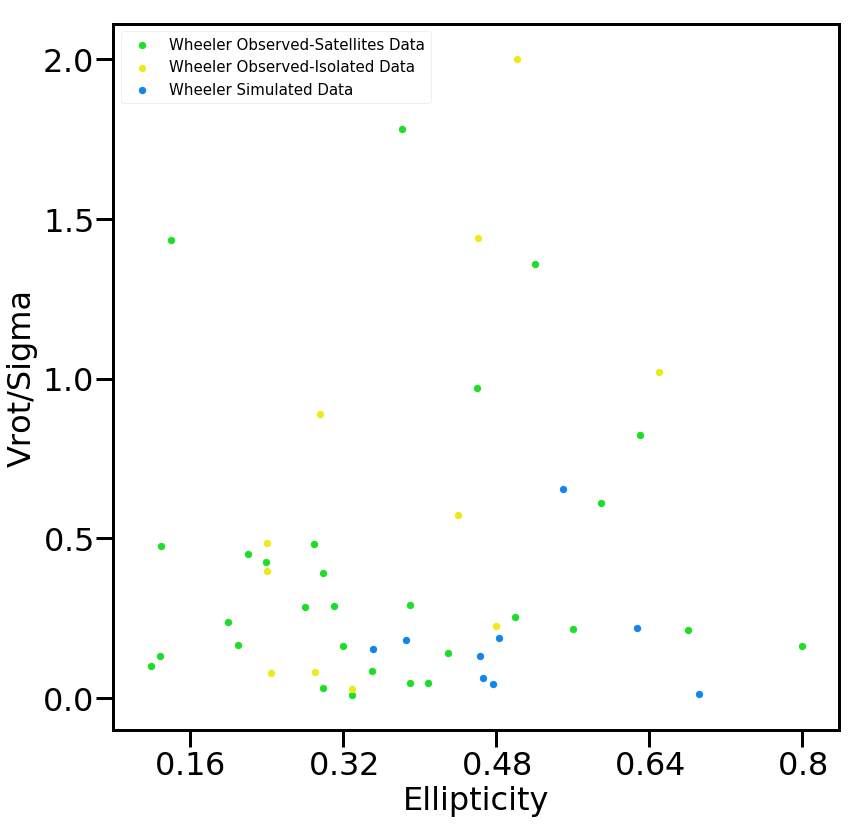

In [58]:
#Ellipticity plot
#Calculating the simulation ellipticities 
axwidth = 3
axlength = 12
fontsize=32

plt.rc('axes',linewidth=axwidth)  #make sure to do this before making any figures

fig = plt.figure(figsize=(13,13))
ax = plt.gca()
#<do plotting>
datax = ellip_data
datay = ellip_velo_data

xtickloc = np.linspace(0,round(max(datax),1),6)
xtickstr = ['$'+str(kk)+'$' for kk in xtickloc]
ytickloc = np.linspace(0,round(max(datay),1),5)
ytickstr = ['$'+str(kk)+'$' for kk in ytickloc]

plt.xticks(xtickloc,xtickstr)
plt.yticks(ytickloc,ytickstr)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for line in ax.get_xticklines() + ax.get_yticklines():
    line.set_markersize(18)
    line.set_markeredgewidth(3)
for tick in ax.xaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fontsize/2)

ax.tick_params(which='major',width=axwidth,length=axlength+5)
ax.tick_params(which='minor',width=axwidth,length=axlength)

#plt.scatter(datax[0:10],datay[0:10],c='r',label='FIRE Data',s=40)
plt.scatter(datax[0:29],datay[0:29],c='#1bde28',label='Wheeler Observed-Satellites Data',s=40)
plt.scatter(datax[30:41],datay[30:41],c='#edea18',label='Wheeler Observed-Isolated Data',s=40)
plt.scatter(datax[42:55],datay[42:55],c='#1384ed',label='Wheeler Simulated Data',s=40)

ax.set_xlabel('Ellipticity',fontsize=32)
ax.set_ylabel('Vrot/Sigma',fontsize=32)
ax.legend(fontsize=15,loc='upper left',framealpha=0.3)
#plt.savefig("FIRE_EllipvsVrot.pdf",overwrite=True)
plt.show()

In [21]:
#code tests
g='./snapshot_m10xa_152.stars.hdf5'
print(g[11:16])

m10xa


In [60]:
#code tests
f_halos = np.loadtxt('./galaxy_center_file.csv',delimiter=',',dtype=object)
f_halos[:,0][0][0:5]
print(f_halos[:,0][2][0:5])
print(f_halos[1][0])
allnames = [i for i in f_halos[:,0][range(len(f_halos[:,0]))]]
print(len(f_halos[:,0]),f_halos[:,0],allnames)
print(f_halos[0][1:4])

m10xh
m10xc_A
(17, array(['m10xc', 'm10xc_A', 'm10xh_A', 'm10xh', 'm10xd_A', 'm10xd',
       'm10xb', 'm10xa', 'm10xe_C', 'm10xe_D', 'm10xe_B', 'm10xe_A',
       'm10xe', 'm10xg', 'm10xg_A', 'm10xi', 'm10xf'], dtype=object), ['m10xc', 'm10xc_A', 'm10xh_A', 'm10xh', 'm10xd_A', 'm10xd', 'm10xb', 'm10xa', 'm10xe_C', 'm10xe_D', 'm10xe_B', 'm10xe_A', 'm10xe', 'm10xg', 'm10xg_A', 'm10xi', 'm10xf'])
['17.0627' '9.648' '12.9653']


In [18]:
#code tests
f = h5py.File(stellar_file)
h= 0.71
PD_dict = f['PartType4']
stars_part = f['PartType4']['Coordinates'][:]/h
stars_mass = f['PartType4']['Masses'][:]*(10**10.0)/h #PD_dict['star']['masses']
stars_vel = f['PartType4']['Velocities'][:]
print(stars_part[1])
print(np.shape(stars_part[0]))
print(PD_dict)
stars_dist_val = get_distance(stars_part, host_center[0]) #did it save?
dist_cut = (stars_dist_val<=50)
print(np.shape(dist_cut))
mass_cut = stars_mass[dist_cut]
print(mass_cut[0:100])
print(len([i for i in dist_cut if i==True]))
print(np.where(dist_cut==True))
print(np.shape(stars_vel))
print(np.shape(mass_cut))
mass_tot = sum(mass_cut)
print(mass_tot)

[ 8498.1746927  14721.08432729 16792.81920474]
(3,)
<HDF5 group "/PartType4" (9 members)>
(792982,)
[2841.991  2858.9756 3179.295  2798.3777 2950.3281 2863.824  3011.0308
 3073.6873 2533.7258 3063.3752 2768.5186 2950.2742 2980.7542 3110.0093
 3058.5605 3155.695  2964.7832 2839.8496 3133.0942 3083.9565 2982.107
 2641.8777 2666.0286 2595.2988 2848.6838 2770.8054 3207.2952 2685.7742
 2633.274  2957.9436 2866.243  2650.6638 3276.85   2949.0542 2768.0798
 3107.158  2719.1953 2795.1846 3084.6562 2753.7292 3125.36   3235.9055
 2690.9854 3223.4448 2692.122  3155.6033 2521.1514 2765.0474 3238.9067
 3074.8738 3076.2476 2669.9822 2983.57   2929.3132 2786.7297 2713.6648
 2620.1753 3166.4456 3208.001  3212.9937 3165.5833 3024.9753 3063.5544
 3176.8071 3121.3604 3038.847  3366.0383 2786.1196 2997.2688 2854.2131
 2978.0725 3199.9902 2753.7666 2963.6758 2946.6494 2961.8398 3334.608
 3045.7292 2935.2964 3189.0134 3123.3228 3146.838  3078.1519 3149.5479
 3294.5493 2554.876  2793.0142 2967.885  2562.2285

In [42]:
#code tests
testlist = np.array([0,1,2,3,4,5,6,7,8,9,10])
testlist[0:11]
mean_test = np.array([[0,2,4,5],[0,3,4,5]])
print(np.mean(mean_test,axis=0))
print(np.__file__)
test_test =np.array([(4,5),(12,234),(1242,355),(25,6)])
part_test = test_test[:,0]
testprt = test_test[:,1]
print(testprt[np.where(max(part_test)==part_test)])
print(2*np.array([1,2,3,4])**2)

[0.  2.5 4.  5. ]
/Users/thomasseive/anaconda2/lib/python2.7/site-packages/numpy/__init__.pyc
[355]
[ 2  8 18 32]
